In [162]:
import sys 
import json
import os
from ast import literal_eval
from pathlib import Path 
import os

# reads in minion statistics and returns dictionary
def readMinionStats(pathToFile):
    stats = open(pathToFile, "r")
    statTypeLoc = 0
    statValLoc = 1
    lines = stats.readlines()
    statsDict = {}
    for line in lines:
        line = line.split(":")
        if len(line) <= 1: 
            continue
        statsDict[line[statTypeLoc]] = literal_eval(line[statValLoc])
    return statsDict

# reads in minizinc file, places stats into statDict
# and solution into solutionDict
def readMinizinc(pathToFile, statDict, solutionDict):
    miniStats = open(pathToFile, "r")
    lines = miniStats.readlines()
    statDict["timeout"] = False
    for line in lines:
        lineJson = json.loads(line)
        lineType = lineJson["type"]
        if lineType == "statistics":
            statDict.update(lineJson["statistics"])
            if "solveTime" in lineJson["statistics"] and lineJson["statistics"]["solveTime"] >= timeoutTimeSecs:
                statDict["timeout"] = True
        elif lineType == "solution":
            solutionDict.update(lineJson["output"]["json"])
        elif lineType == "comment" and lineJson["comment"] == "% Time limit exceeded!":
            statDict["timeout"] = True

timeoutTimeSecs = 3600 # default timeout time, otherwise read from timout
with open(str(Path().resolve()) + "/../bash/constants/timeout.txt", "r") as timeout_file:
    timeout_millisecs = timeout_file.readline()
    timeoutTimeSecs = int(literal_eval(timeout_millisecs)/1000)
print('timeout set in seconds as', timeoutTimeSecs)

# gets the data from statFile path
def fetch_data(statFile, isEprime, problemName=""):
    statInfo = {}
    if isEprime:
        # .info files
        statInfo = readMinionStats(statFile)
    else:
        miniSolution = {}
        readMinizinc(statFile, statInfo, miniSolution)
        # LEGACY to save the minizinc solution as json
        # slashes = [i for i in range(len(statFile)) if statFile[i] == '/']
        # print(statFile + "/../../" +  + ".json")
        # with open(problemName + "/" + statFile[slashes[-1]+1:] + ".json", "w") as f:
        #     json.dump(miniSolution, f)
    return statInfo

timeout set in seconds as 3600


In [163]:



import statistics

dataLocation = "../../instances_and_solutions/"

wordpress = "wordpress"
wordpressNoSymm = "wordpressNoSymm"
quasigroup = "quasigroup"
quasigroupOcc = "quasigroupOcc"
tournament = "tournament"
tournamentFree = "tournamentFree"
mspsp = "mspsp"
mspspNoStdLib = "mspspNoStdLib"
cvrptw = "cvrptw"
roster = "roster"
rosterFree = "rosterFree"


median_location = 1
with open(str(Path().resolve()) + "/../../bash/constants/numberOfRuns.txt", "r") as num_runs_file:
    num_runs = num_runs_file.readline()
    median_location = int(literal_eval(num_runs)//2)
    
# biggest_deviation = 0 # LEGACY debug

stdDevLoc = "stdDev"

# solvers = ["chuffed", "gecode"]
solvers = ["chuffed"]
# problemFlags = ["noFree", "free"]
problemFlags = ["free"]
optimisations = ["O0_S0", "O2_S1", "O3_S2"]
mzn_optimisations = ["O0", "O1", "O5"]
dataKeys = ["time", "solveTime", "initTime", "timeout"]
problemNames = [quasigroup, quasigroupOcc, wordpress, wordpressNoSymm, tournament, mspsp, mspspNoStdLib, cvrptw, roster]
noOccProblems = [quasigroup, wordpress, wordpressNoSymm, tournamentFree, tournament, mspsp, cvrptw, rosterFree, roster]
originalProblems = [quasigroup, wordpress, wordpressNoSymm, tournament, mspsp, cvrptw, roster]
freeOriginalProblems = [quasigroup, wordpress, wordpressNoSymm, tournamentFree, mspsp, cvrptw, rosterFree]

problems = []
for i in problemNames:
    for j in solvers:
        for k in problemFlags:
            problems.append(i + "_" + k + "_" + j)

freeProblems = [x for x in problems if "_free_" in x]
noFreeProblems = [x for x in problems if "_noFree_" in x]
chuffedProblems = [x for x in problems if "chuffed" in x]
gecodeProblems = [x for x in problems if "gecode" in x]

# print(problems)
# print(noFreeProblems)
# print(freeProblems)
# print(chuffedProblems)
# print(gecodeProblems)

eprimePath = "/eprime/"
minizincPath = "/minizinc/"

# gets the median from the inputted runs array
# calculates the standard deviation as well
def getMedianStdev(runs):
    # global biggest_deviation
    # sort runs by overall time
    sortedLst = sorted(runs, key=lambda x: x["time"])
    res = sortedLst[median_location].copy()

    for key in dataKeys:
        # res[key] = statistics.mean([rn[key] for rn in runs])
        if key != "timeout":
            res[key + "_stdev"] = statistics.stdev([rn[key] for rn in runs])
            res[key + "_mean"] = statistics.mean([rn[key] for rn in runs])
            # LEGACY coefficient variation
            # res[key + "_CV"] = res[key + "_stdev"] / res[key + "_mean"]
            # biggest_deviation = max(biggest_deviation, res[key + "_stdev"] / res[key + "_mean"])
            # print(biggest_deviation)
            # print("stdv: ", res[key + "_stdev"], "mean: ", res[key + "_mean"], "median: ", res[key], "CV: ", res[key + "_stdev"] / res[key])
        res[key + "_all_runs"] = [rn[key] for rn in runs]
    return res

def getData(path, isEprime):
    runs = []
    # path is path to instance directory
    # generate run (ie. 3 instance files) data
    # returns the median of the 3 runs
    for entry in os.scandir(path):
        if os.path.isdir(entry):
            continue
        data = fetch_data(entry.path, isEprime)
        if isEprime:
            # stadardises data to minizinc format
            data = processEprime(data)
        # case of unknown message, ex. quasigroupOcc.mzn run on instance 50.json
        if not isEprime and 'time' not in data:
            data["timeout"] = True
            data["initTime"] = 0.5 # TODO dummy value
            data["time"] = timeoutTimeSecs

        if data["timeout"]:
            data["solveTime"] = timeoutTimeSecs
            data["time"] = timeoutTimeSecs
        
        runs.append(data)

    if len(runs) > 0:
       return getMedianStdev(runs)
    else:
        return {}

# stadardises data to minizinc format
def processEprime(data):
    d = {}
    d["time"] = data['SolverTotalTime'] + data['SavileRowTotalTime']        
    d["solveTime"] = data['SolverTotalTime']
    d["initTime"] = data['SavileRowTotalTime']
    d["timeout"] = data['SolverTimeOut'] == 1
    # gecode does not give timeout
    if d["time"] >= timeoutTimeSecs:
        d["time"] = timeoutTimeSecs
        d["timeout"] = True
    return d

# eprime dictionary
# eprimeData[problemName_free/NoFree_chuffed/gecode][opt][(instanceName, values)]
eprimeData = {}
# minizinc dictionary
# minizincData[problemName_free/NoFree_chuffed/gecode][opt][(instanceName, values)]
minizincData = {}

# extract eprime 
def extract_eprime(problemLocation, folder_name, problemIndex, solver, flag):
    opt = {}
    eprimeProblemLocation = problemLocation + eprimePath + folder_name +"/timing"
    # copy noFree data into free index of solver
    # if flag == "free" and solver == "chuffed":
    #     eprimeProblemLocation = problemLocation + eprimePath + "noFree_" + solver + "/timing"
    # copy normal problem data into nostdlib problem index
    if "NoStdLib" in eprimeProblemLocation:
        eprimeProblemLocation = eprimeProblemLocation.replace("NoStdLib", "")
    for optimize in os.scandir(eprimeProblemLocation):
        if optimize.name == "infor":
            continue
        res = []
        for problem in os.scandir(optimize.path):
            res.append((problem.name, getData(problem.path, True)))
        opt[optimize.name] = res
    eprimeData[problemIndex] = opt

# extracts all instance files for a problem into minizincData
def extract_mzn(problemLocation, folder_name, problemIndex):
    opt = {}
    mzn_path_to_scan = problemLocation + minizincPath + folder_name
    # save mspsp without std lib
    if mspspNoStdLib in problemLocation:
        mzn_path_to_scan = dataLocation + "mspsp/minizinc/noStdLib/" + folder_name
    for optimisations in os.scandir(mzn_path_to_scan):
        res = []
        for problem in os.scandir(optimisations.path):
            # for each instance name
            if os.path.isdir(problem.path) and problem.name != "json":
                res.append((problem.name, getData(problem.path, False)))
        opt[optimisations.name]
    minizincData[problemIndex] = opt

# exports the eprime data to json to 
# use in the objective graphs
# def export_data():
#     # Serializing json
#     json_object = json.dumps(eprimeData, indent=4) 
#  
#     with open("eprime_data.json", "w") as outfile:
#         outfile.write(json_object)


for i in problemNames:
    for flag in problemFlags:
        for solver in solvers:
            print(i, flag)
            folder_name = flag + "_" + solver
            problemLocation = dataLocation + i 
            # ex. quasigroup_free_chuffed
            problemIndex = i + "_" + flag + "_" + solver
            extract_eprime(problemLocation, folder_name, problemIndex, solver, flag)
            extract_mzn(problemLocation, folder_name, problemIndex)

# print(biggest_deviation)
# export_data()
# print(minizincData)

quasigroup noFree
quasigroup free
quasigroupOcc noFree
quasigroupOcc free
wordpress noFree
wordpress free
wordpressNoSymm noFree
wordpressNoSymm free
tournament noFree
tournament free
mspsp noFree
mspsp free
mspspNoStdLib noFree
mspspNoStdLib free
cvrptw noFree
cvrptw free
roster noFree
roster free
0.7063312517042973


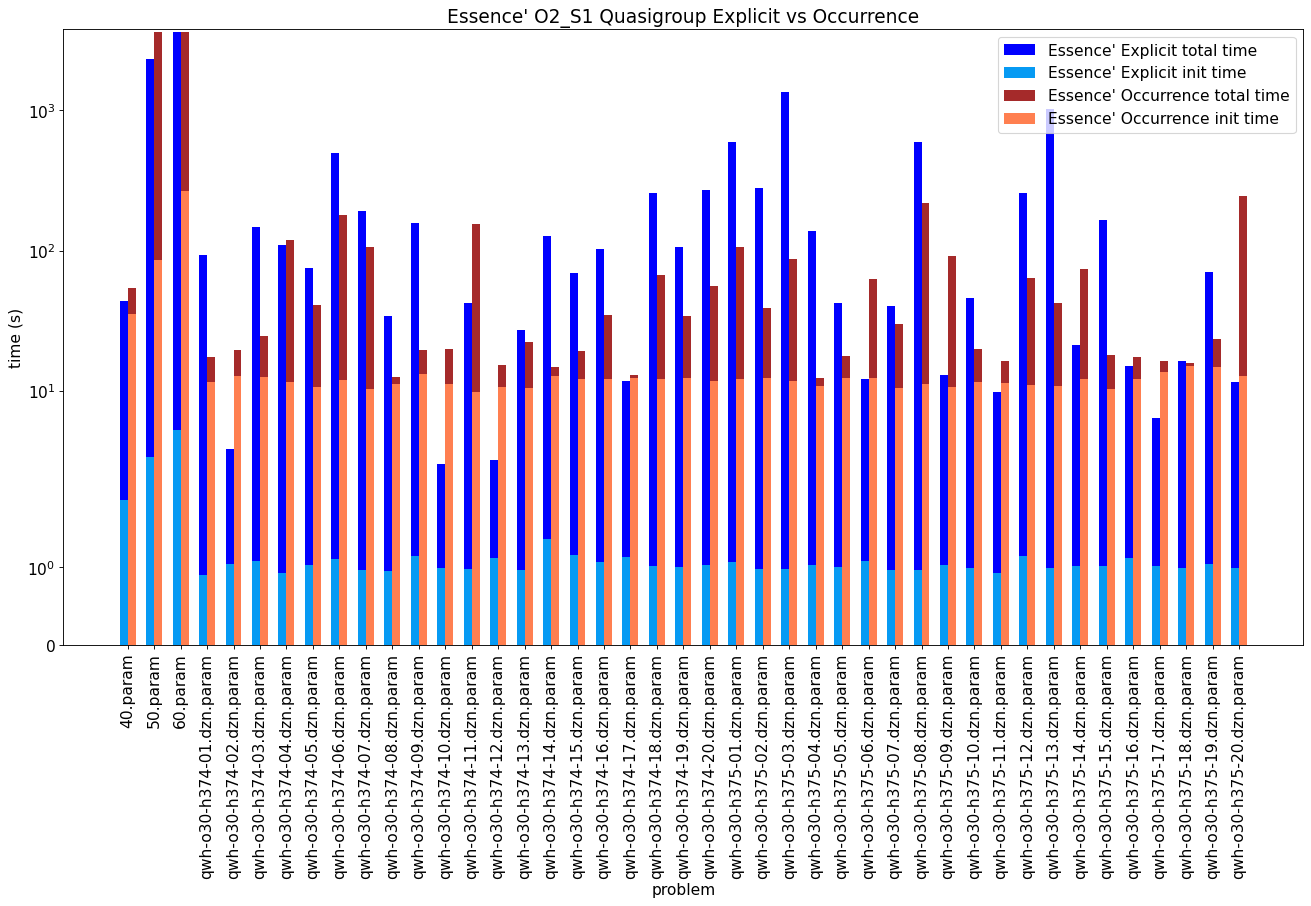

In [164]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

# TODO why use an index here than the naming convention already created?
def getData(dataToExtract):
    # sorts by the problem name
    xData, yData = zip(*sorted(dataToExtract))
    extractedY = []
    for i in dataKeys:
        extractedY.append(list(map(lambda y : y[i], yData)))
        if i != "timeout":
            extractedY.append(list(map(lambda y : y[i+"_stdev"], yData)))
    return (xData, *extractedY)



eprimeX, eprimeTime, eprimeTimeStdDev, eprimeSolverTime, eprimeSolverTimeStd, eprimeInit, eprimeInitStd, eprimeCompleted = getData(eprimeData["quasigroup_free_chuffed"]["O2_S1"])
eprimeOccX, eprimeOccTime, eprimeOccTimeStd, eprimeOccSolverTime, eprimeOccSolverStd, eprimeOccInit, eprimeOccInitStd, eprimeOccCompleted = getData(eprimeData["quasigroupOcc_free_chuffed"]["O2_S1"])

# print(set(eprimeOccX).difference(set(eprimeX)))
# print(set(eprimeX).difference(set(eprimeOccX)))
# print(len(eprimeX))
# print(len(eprimeOccX))

eprimeX = list(map(str, eprimeX))
eprimeOccX = list(map(str, eprimeOccX))

ind = np.arange(len(eprimeX))
width = 0.3

figure(figsize=(20, 10), dpi=80)
plt.title("Essence' O2_S1 Quasigroup Explicit vs Occurrence")
plt.bar(ind, eprimeTime, width, label="Essence' Explicit total time", color="blue")
plt.bar(ind, eprimeInit, width, label="Essence' Explicit init time",  color="#069AF3")
# plt.bar(ind+width, eprimeOccTime, width, label="MiniZinc", color="red")
# plt.bar(ind+width, eprimeOcc, width, label="MiniZinc init time" , color="maroon")
plt.bar(ind+width, eprimeOccTime, width, label="Essence' Occurrence total time", color="brown")
plt.bar(ind+width, eprimeOcc, width, label="Essence' Occurrence init time", color="coral")
# plt.scatter(eprimeX, eprimeY, label="eprime")
# plt.scatter(eprimeOccX, minizincY, label="minizinc")
plt.legend(loc="best")
plt.xticks(ind+width/2, eprimeOccX)
plt.xticks(rotation = 90)
plt.xlabel("problem")
plt.ylabel("time (s)")
plt.yscale("symlog")

In [165]:
import itertools

allEprimeTimings = {}
allMinizincTimings = {}

problemIndex = 0
timingIndex = 1
timingStdevIndex = 2
solverTimeIndex = 3
solverStdevIndex = 4
initIndex = 5
initIndexStdev = 6
timeoutIndex = 7

titleNames = {}
titleNames[timingIndex] = "total time"
titleNames[timingStdevIndex] = "total time standard deviation" 
titleNames[solverTimeIndex] = "solver time"
titleNames[solverStdevIndex] = "solver time standard deviation"
titleNames[initIndex] = "initialization time"
titleNames[initIndexStdev] = "initialization time standard deviation"
titleNames[timeoutIndex] = "timeout"

for i in problems:
    allMinizincTimings[i] = {}
    for mzn_opt in mzn_optimisations:
        allMinizincTimings[i][mzn_opt] = getData(minizincData[i])
    allEprimeTimings[i] = {}
    for j in optimisations:
        allEprimeTimings[i][j] = getData(eprimeData[i][j])

# marker = itertools.cycle((',', '+', 'o', '*', '^', 'x', 's', 'v','2', 'd', 'H', 'X'))
marker = itertools.cycle(('v', 'o', 'P', 's'))

maxLine = []

def setupPlotSolverSolver(graphTitle="Minizinc vs Essence'", indexOfInterest=timingIndex, plotTimeout=True):
    # fig = plt.figure(figsize=(20, 20), dpi=80)
    figure(figsize=(10, 10), dpi=80)
    # ax = plt.axes()
    if plotTimeout:
        plt.plot([0, timeoutTimeSecs], [0, timeoutTimeSecs])
    plt.xlabel("time MiniZinc (s)")
    plt.ylabel("time Essence' (s)")
    maxLine = []
    # ax.set_xscale("log")
    # ax.set_yscale("log")
    plt.yscale("symlog")
    plt.xscale("symlog")
    plt.title(graphTitle + " " + titleNames[indexOfInterest])
    plt.rcParams['font.size'] = 14

def createOccurencePlot(opt, occProblem, explicitProblem, annotate=False, indexOfInterest=timingIndex, errorbars=False):
    x, y = occProblem[indexOfInterest], explicitProblem[indexOfInterest]
    # chosenColor = next(color)
    plt.xlabel("time occurrence (s)")
    plt.ylabel("time explicit (s)")
    # plt.scatter(x, y, label= quasigroup + " " + opt, marker=next(marker), color=chosenColor)
    plt.scatter(x, y, label=quasigroup + " " + opt, marker=next(marker))
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    maxLine.extend(x)
    maxLine.extend(y)
    if annotate:
        for j in range(len(occProblem[problemIndex])):
            plt.annotate(occProblem[problemIndex][j], (occProblem[indexOfInterest][j], explicitProblem[indexOfInterest][j]))
    if errorbars:
        stdDevLoc = indexOfInterest+1
        # plt.errorbar(x, y, yerr=explicitProblem[stdDevLoc], xerr=occProblem[stdDevLoc], ls='none', color=chosenColor, lw=1)
        plt.errorbar(x, y, yerr=explicitProblem[stdDevLoc], xerr=occProblem[stdDevLoc], ls='none', lw=1)



def createPlot(opt_index, problemList, annotate=False, errorbars=False, indexOfInterest=timingIndex):
    for i in problemList:
        m_opt = mzn_optimisations[opt_index]
        e_opt = optimisations[opt_index]
        minizincProblem = allMinizincTimings[i][m_opt]
        essenceProblem = allEprimeTimings[i][e_opt]
        x, y = minizincProblem[indexOfInterest], essenceProblem[indexOfInterest]
        maxLine.extend(x)
        maxLine.extend(y)
        # chosenColor = next(color)
        labels = i + " E-" + e_opt + " M-" + m_opt
        if errorbars:
            stdDevLoc = indexOfInterest+1
            plt.errorbar(x, y, yerr=essenceProblem[stdDevLoc], 
            xerr=minizincProblem[stdDevLoc], label=labels, fmt=next(marker), ls='none', lw=0.5, capsize=2)
        else:
            plt.scatter(x, y, label=labels, marker=next(marker))
        if annotate:
            for j in range(len(minizincProblem[problemIndex])):
                plt.annotate(minizincProblem[problemIndex][j], (minizincProblem[indexOfInterest][j], essenceProblem[indexOfInterest][j]))
        plt.xlim(left=0)
        plt.ylim(bottom=0)
    if len(problemList) == 1:
        plt.title("Minizinc vs Essence' " + problemList[0] + " " + titleNames[indexOfInterest])

def plotAllOpts(problemList, annotate=False, errorbars=False, indexOfInterest=timingIndex):
    for opt_index in range(len(optimisations)):
        createPlot(opt_index, problemList, annotate, errorbars, indexOfInterest)

# box = plt.get_position()
# plt.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc="best")

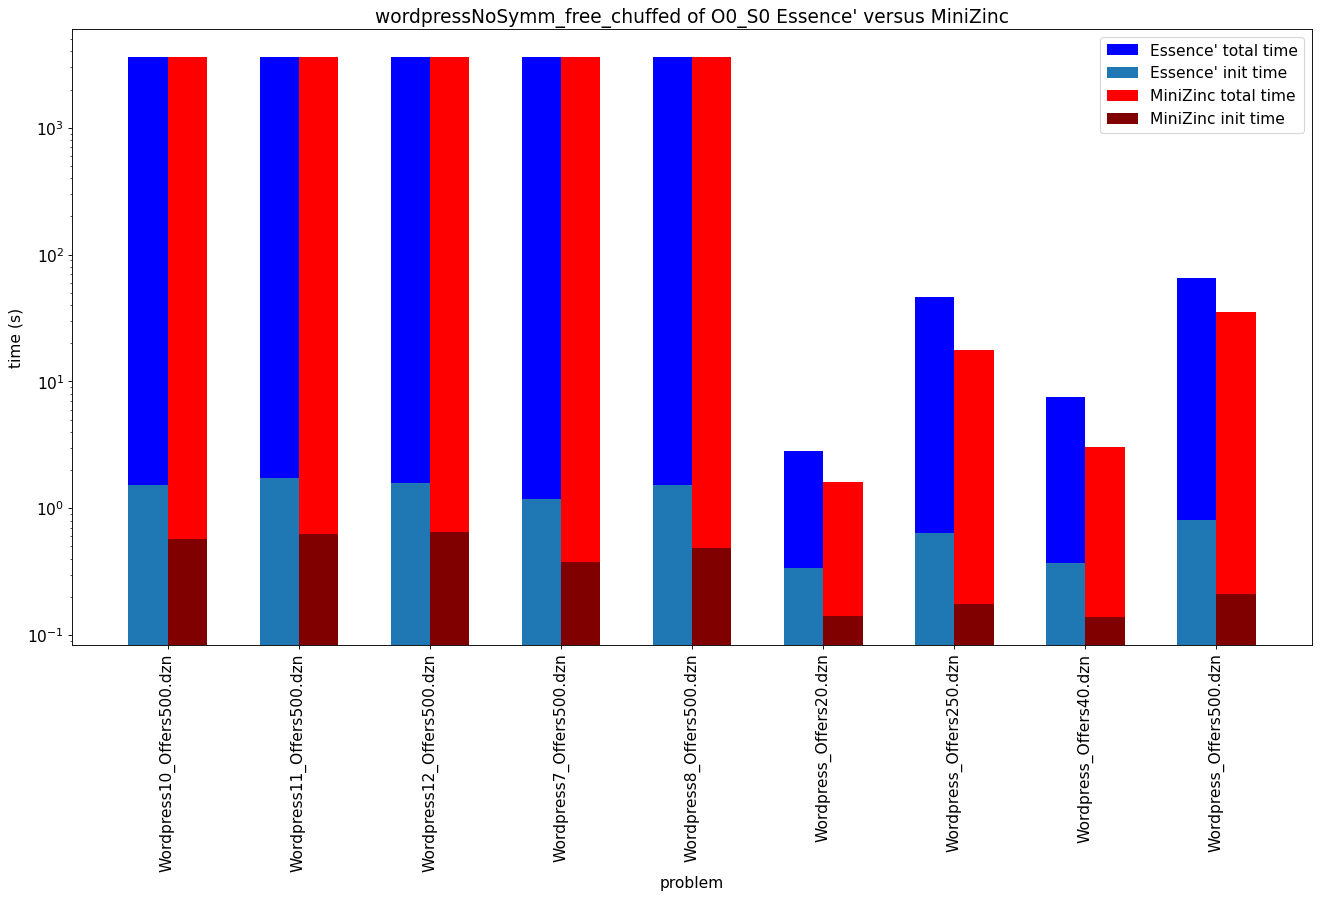

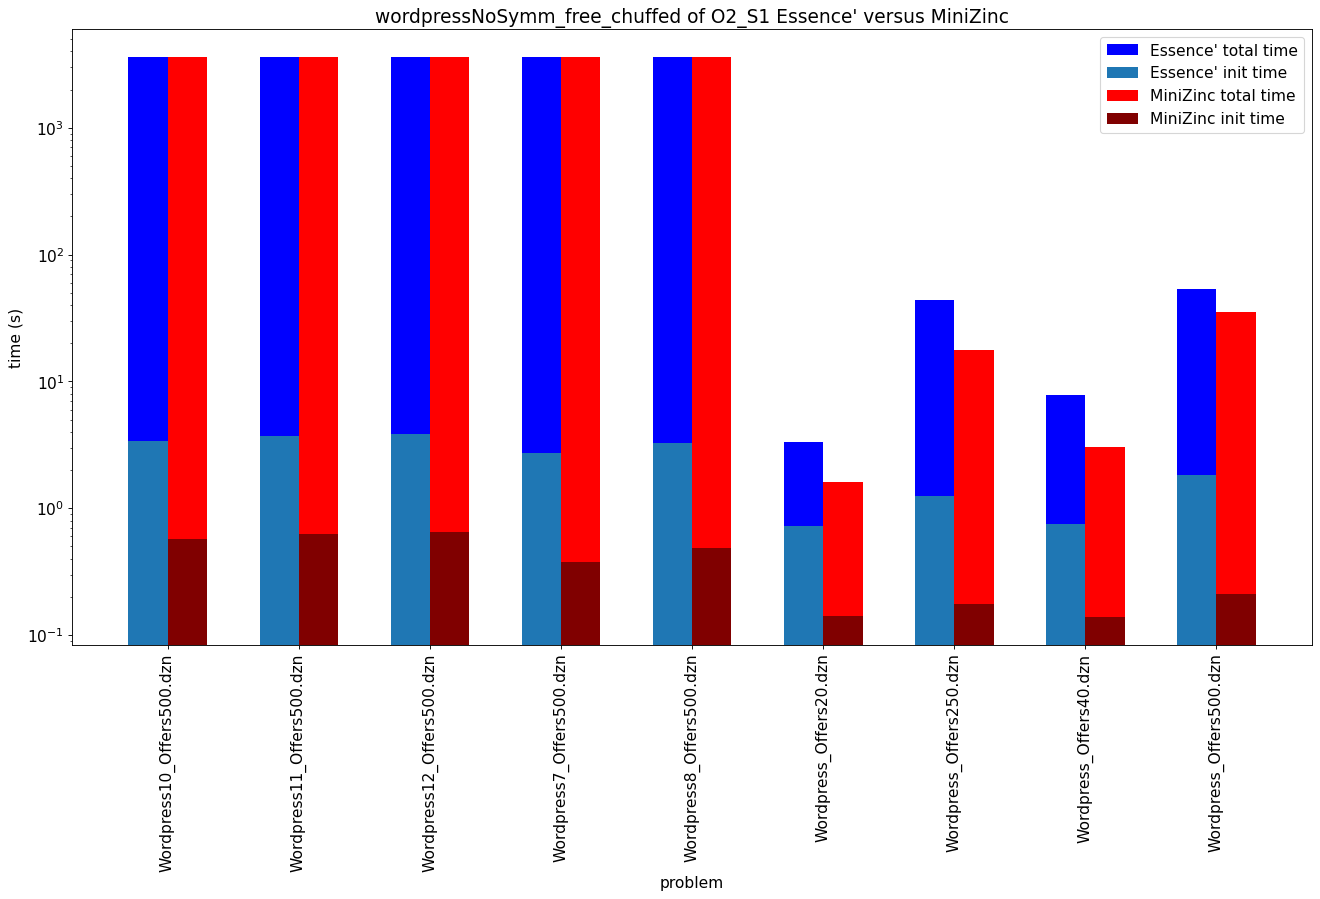

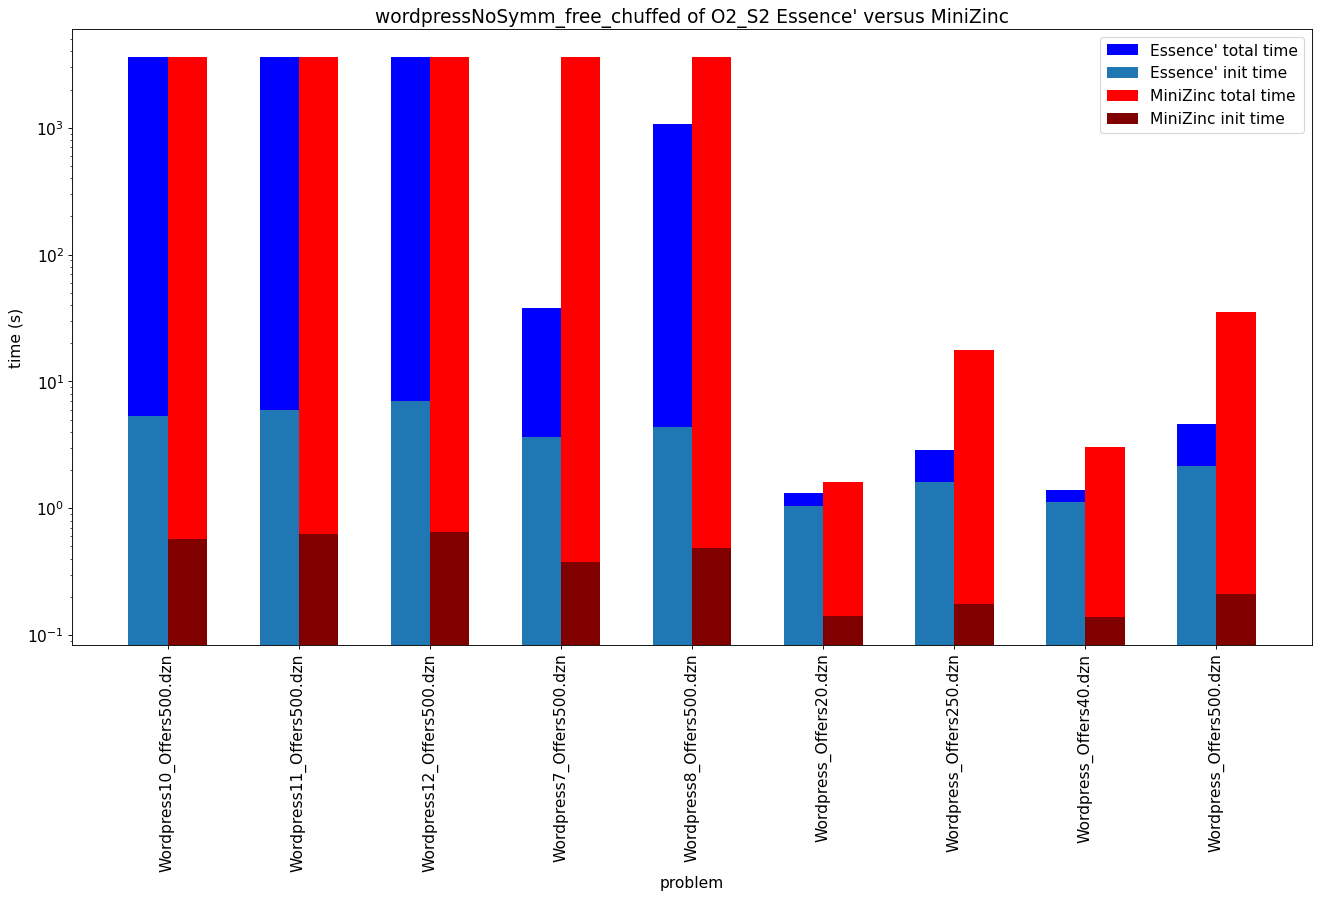

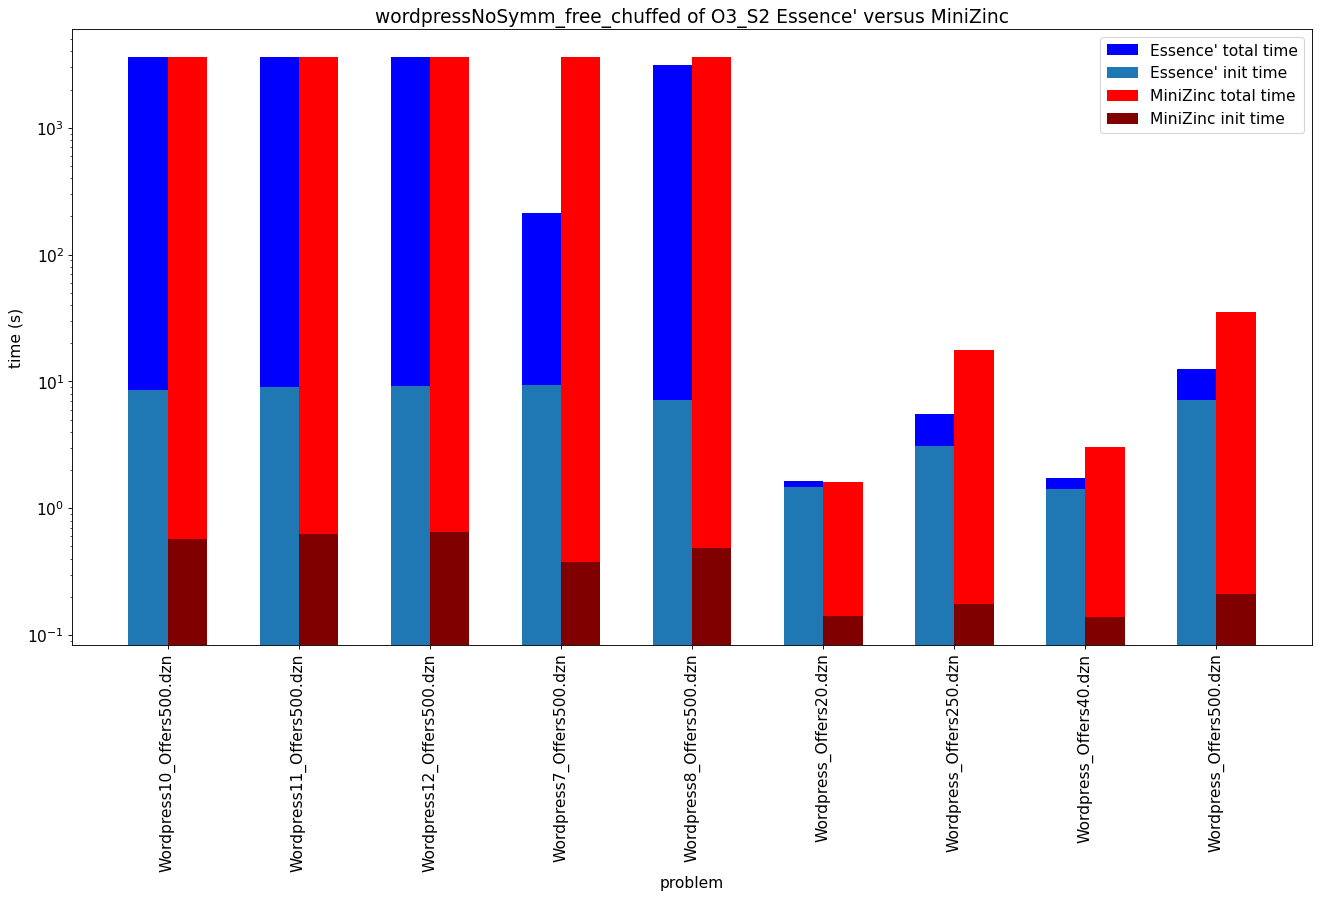

In [166]:

def createBarTimingsInit(opt_index, problem):
    eprime_opt = optimisations[opt_index]
    mzn_opt = mzn_optimisations[opt_index]
    ind = np.arange(len(allEprimeTimings[problem][eprime_opt][timingIndex]))
    width = 0.3
    figure(figsize=(20, 10), dpi=80)
    plt.rcParams['font.size'] = 14
    plt.bar(ind, allEprimeTimings[problem][eprime_opt][timingIndex], width, label="Essence' total time", color="blue")
    plt.bar(ind, allEprimeTimings[problem][eprime_opt][initIndex], width, label="Essence' init time")
    plt.bar(ind+width, allMinizincTimings[problem][mzn_opt][timingIndex], width, label="MiniZinc total time", color="red")
    plt.bar(ind+width, allMinizincTimings[problem][mzn_opt][initIndex], width, label="MiniZinc init time" , color="maroon")
    plt.legend(loc="best")
    plt.title(problem + " of " + eprime_opt + " Essence' versus MiniZinc of " + mzn_opt)
    plt.xticks(ind+width/2, allMinizincTimings[problem][mzn_opt][problemIndex])
    plt.xticks(rotation = 90)
    plt.xlabel("problem")
    plt.ylabel("time (s)")
    plt.yscale("log")

# for problem in chuffedProblems:
for problem in ["wordpressNoSymm_free_chuffed"]:
    for opt in range(len(optimisations)):
        createBarTimingsInit(opt, problem)

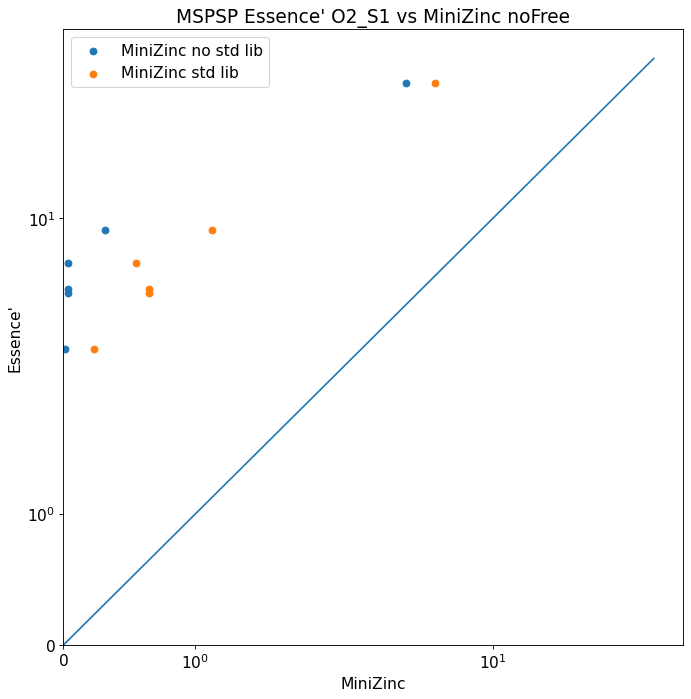

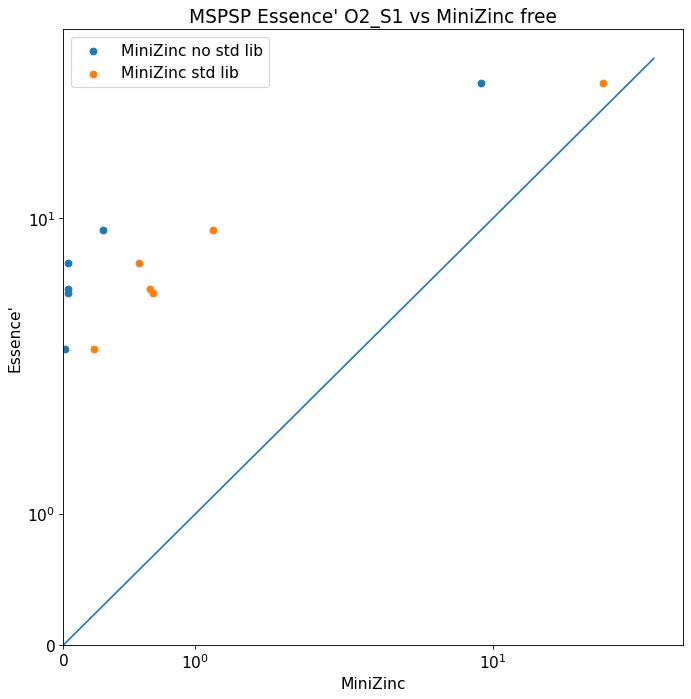

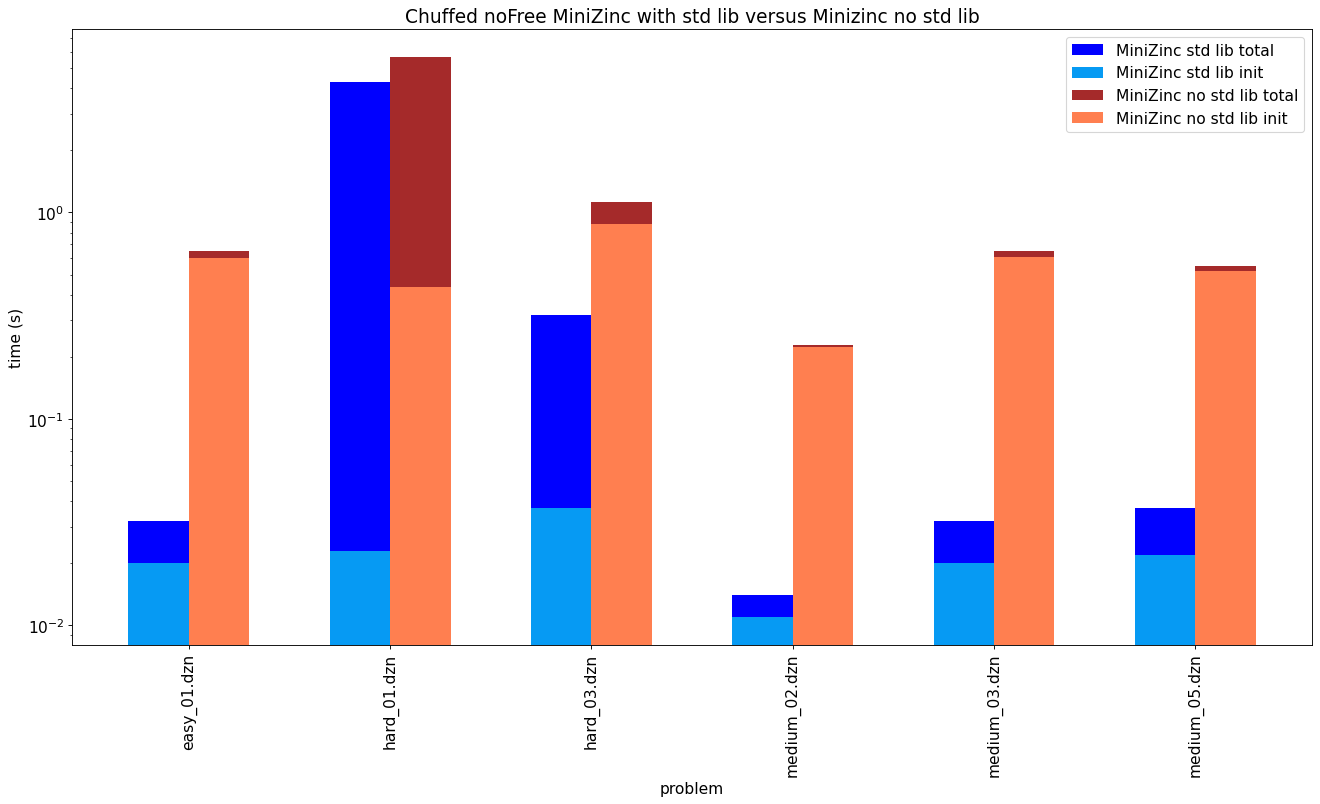

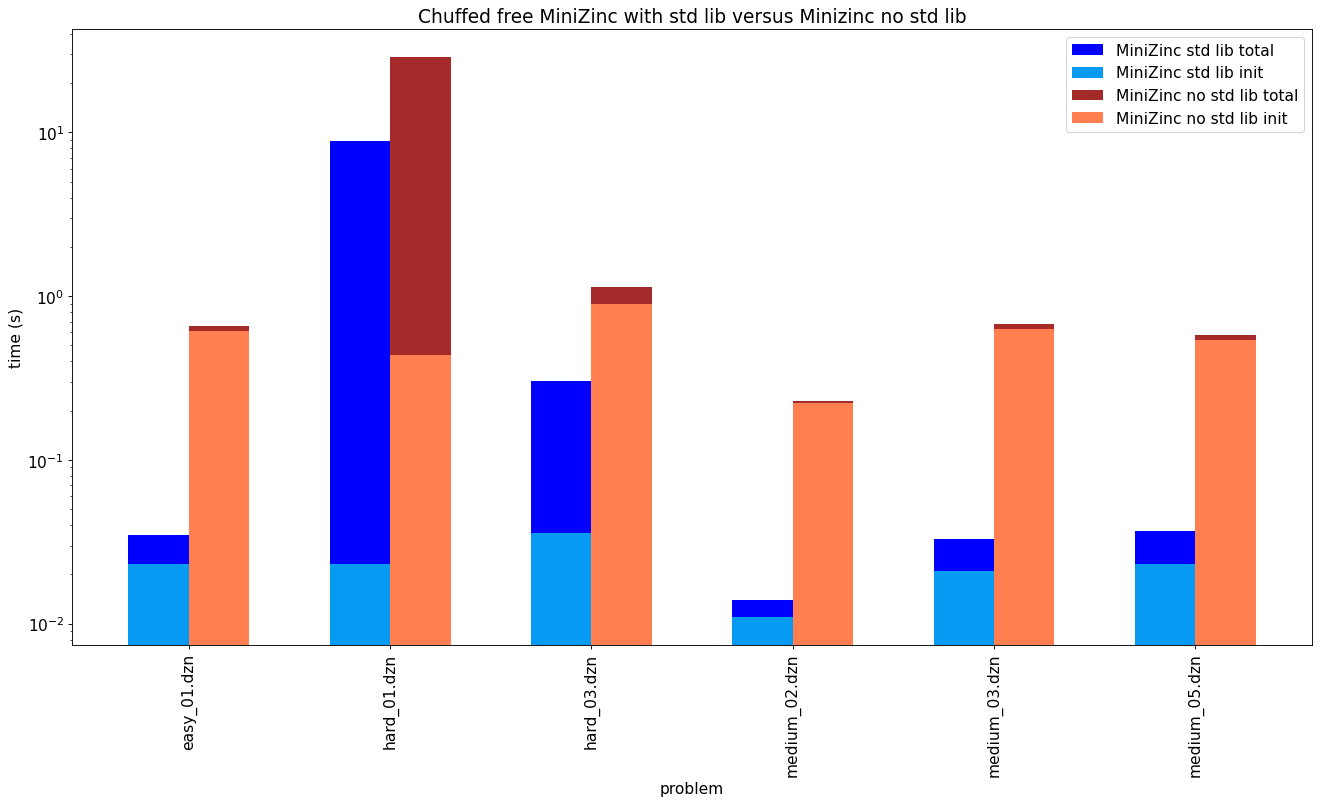

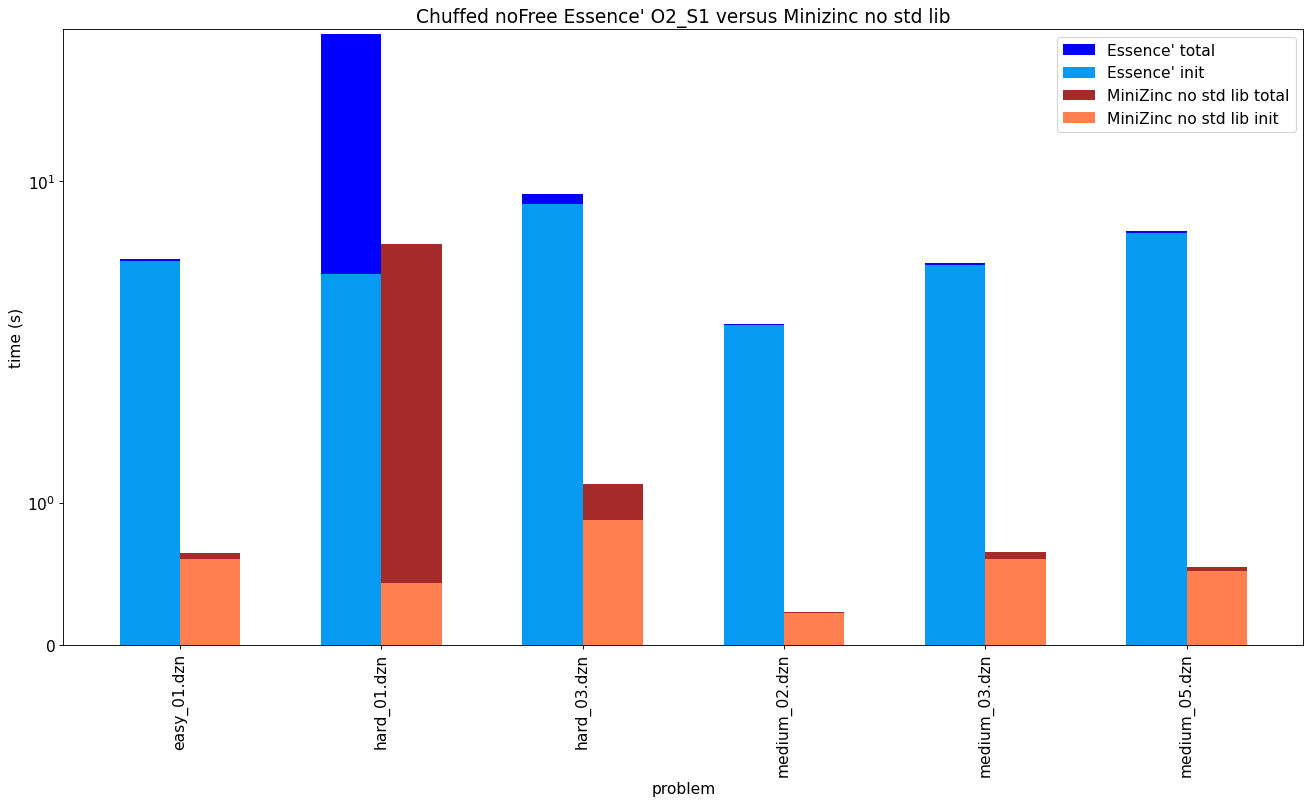

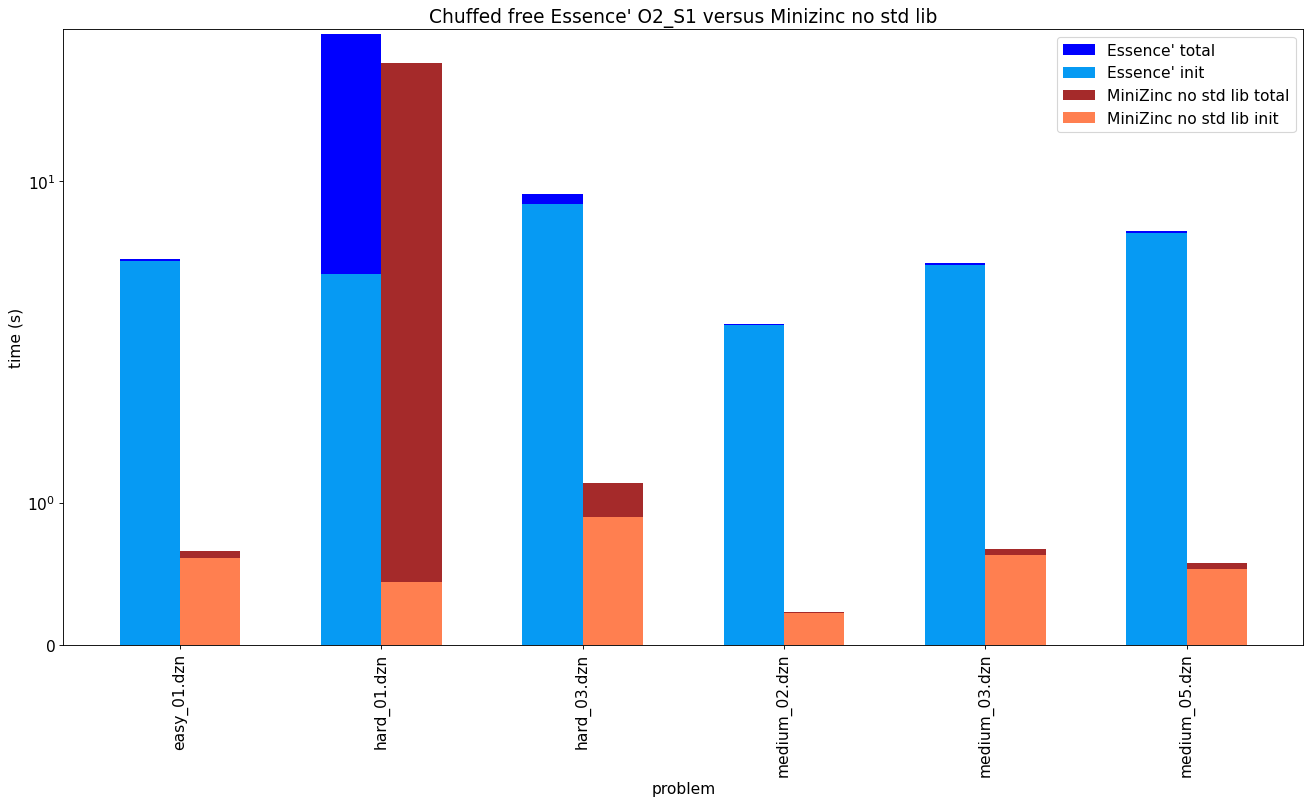

In [167]:
# indx_of_interest=timingIndex

# for opt in ["O2_S1"]:
#     for flag in problemFlags:
#         figure(figsize=(10, 10), dpi=80)
#         plt.rcParams['font.size'] = 14
#         plt.ylabel("Essence'")
#         plt.xlabel("MiniZinc")
#         plt.yscale("symlog")
#         plt.xscale("symlog")
#         plt.title("MSPSP Essence' " + opt  + " vs MiniZinc" + " " + flag)
#         eprimeY = allEprimeTimings[mspspNoStdLib + "_" + flag + "_chuffed"][opt][indx_of_interest]
#         minizincXNoStdLib = allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][indx_of_interest]
#         minizincX = allMinizincTimings[mspsp + "_" + flag + "_chuffed"][indx_of_interest]
#         maxLine = []
#         maxLine.extend(eprimeY)
#         maxLine.extend(minizincXNoStdLib)
#         maxLine.extend(minizincX)
#         end = max(maxLine)+10
#         plt.scatter(minizincX, eprimeY, label="MiniZinc no std lib")
#         plt.scatter(minizincXNoStdLib, eprimeY, label="MiniZinc std lib")
#         # plt.plot([0,end], [0,0], color="black", linewidth=0.5)
#         plt.plot([0,end],[0,end])
#         plt.xlim(left=0)
#         plt.ylim(bottom=0)
#         plt.legend()
# ind = np.arange(len(allEprimeTimings[problem][opt][timingIndex]))
# width = 0.3


# for flag in problemFlags:
#     ind = np.arange(len(allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][timingIndex]))
#     width = 0.3
#     figure(figsize=(20, 10), dpi=80)
#     plt.rcParams['font.size'] = 14
#     plt.bar(ind, allMinizincTimings[mspsp + "_" + flag + "_chuffed"][timingIndex], width, label="MiniZinc std lib total", color="blue")
#     plt.bar(ind, allMinizincTimings[mspsp + "_" + flag + "_chuffed"][initIndex], width, label="MiniZinc std lib init", color="#069AF3")
#     plt.bar(ind+width, allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][timingIndex], width, label="MiniZinc no std lib total", color="brown")
#     plt.bar(ind+width, allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][initIndex], width, label="MiniZinc no std lib init" , color="coral")
#     plt.legend(loc="best")
#     plt.title("Chuffed " + flag + " MiniZinc with std lib versus Minizinc no std lib")
#     plt.xticks(ind+width/2, allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][problemIndex])
#     plt.xticks(rotation = 90)
#     # plt.xticks(ind+width/2, allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][timingIndex])
#     plt.xticks(rotation = 90)
#     plt.xlabel("problem")
#     plt.ylabel("time (s)")
#     plt.yscale("log")

# for flag in problemFlags:
#     ind = np.arange(len(allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][timingIndex]))
#     width = 0.3
#     figure(figsize=(20, 10), dpi=80)
#     plt.rcParams['font.size'] = 14
#     plt.bar(ind, allEprimeTimings[mspsp + "_" + flag + "_chuffed"]["O2_S1"][timingIndex], width, label="Essence' total", color="blue")
#     plt.bar(ind, allEprimeTimings[mspsp + "_" + flag + "_chuffed"]["O2_S1"][initIndex], width, label="Essence' init", color="#069AF3")
#     plt.bar(ind+width, allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][timingIndex], width, label="MiniZinc no std lib total", color="brown")
#     plt.bar(ind+width, allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][initIndex], width, label="MiniZinc no std lib init", color="coral")
#     plt.legend(loc="best")
#     plt.title("Chuffed " + flag + " Essence' O2_S1 versus Minizinc no std lib")
#     plt.xticks(ind+width/2, allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][problemIndex])
#     plt.xticks(rotation = 90)
#     plt.xlabel("problem")
#     plt.ylabel("time (s)")
#     plt.yscale("symlog")

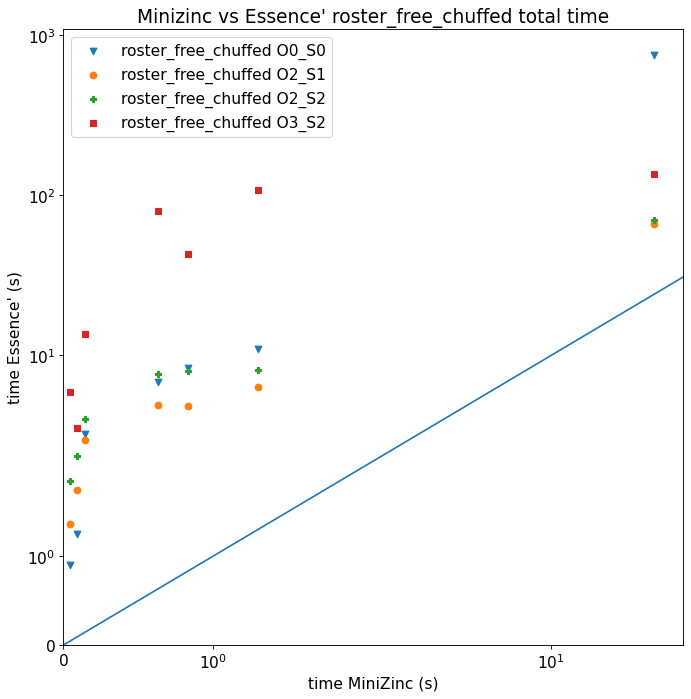

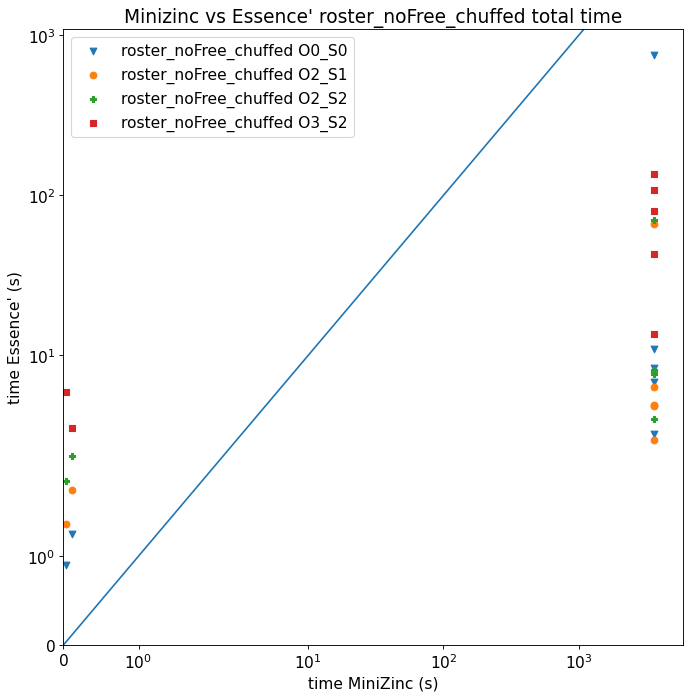

In [168]:
for p in ["roster_free_chuffed"]:
    setupPlotSolverSolver(plotTimeout=False)
    plotAllOpts([p])
    plt.legend(loc="best")
    end = [0, max(maxLine)]
    plt.plot(end, end)

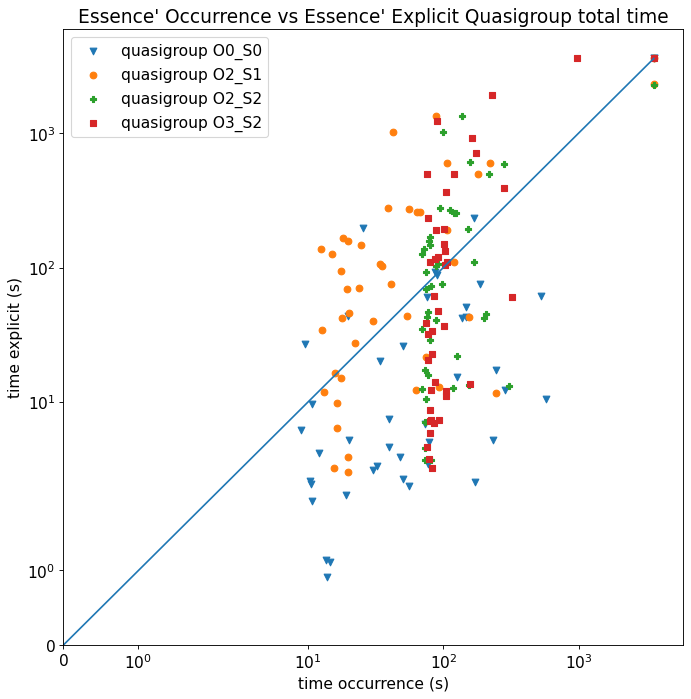

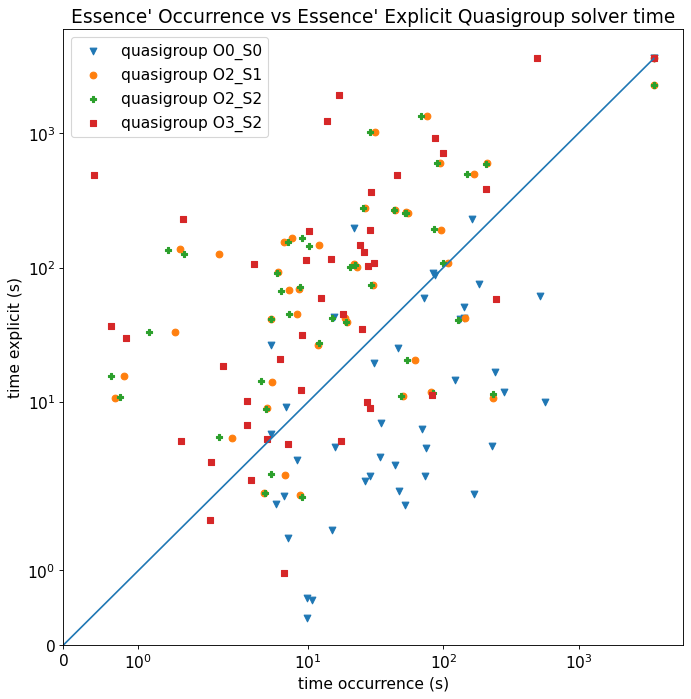

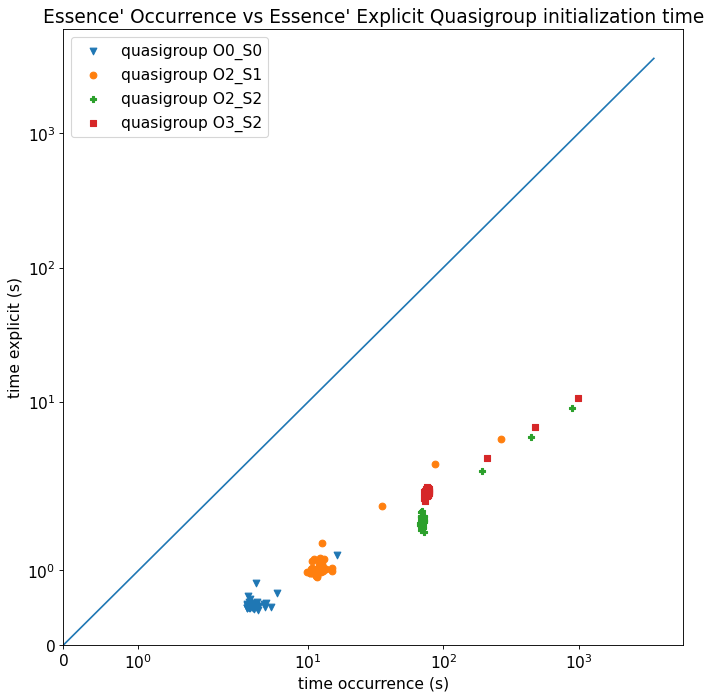

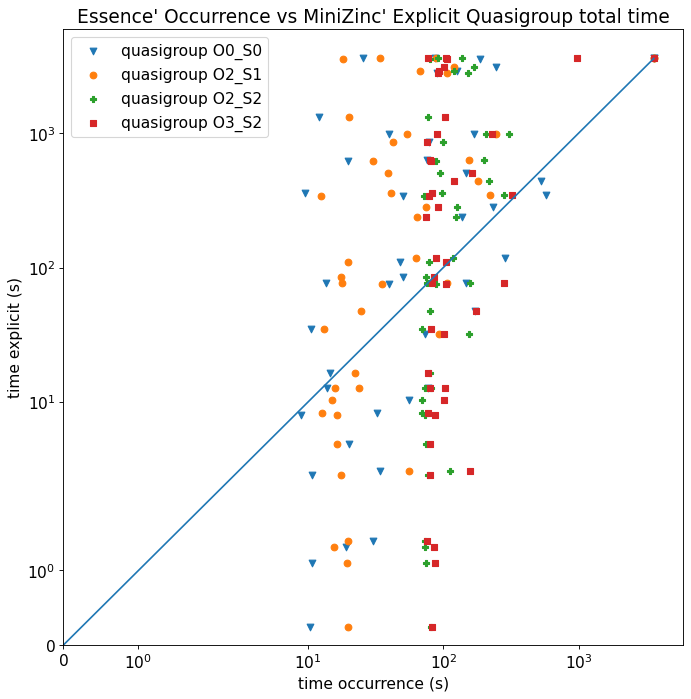

In [169]:
def occurrencePlot(index):
    setupPlotSolverSolver("Essence' Occurrence vs Essence' Explicit Quasigroup", index)
    for solver in ["chuffed"]:
        for flag in ["free"]:
            for j in optimisations:
                createOccurencePlot(j, allEprimeTimings[quasigroupOcc + "_" + flag + "_" + solver][j], allEprimeTimings[quasigroup  + "_" + flag + "_" + solver][j], indexOfInterest=index)
    plt.legend(loc="best")

occurrencePlot(timingIndex)
occurrencePlot(solverTimeIndex)
occurrencePlot(initIndex)

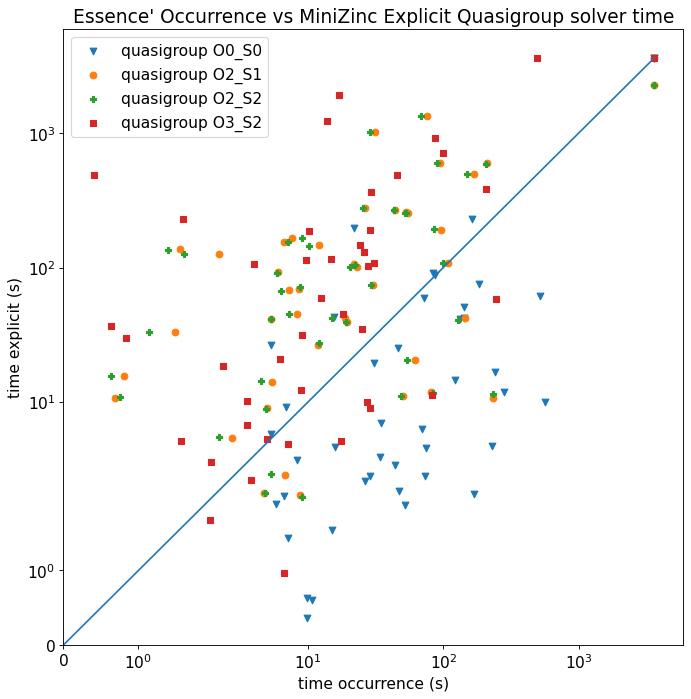

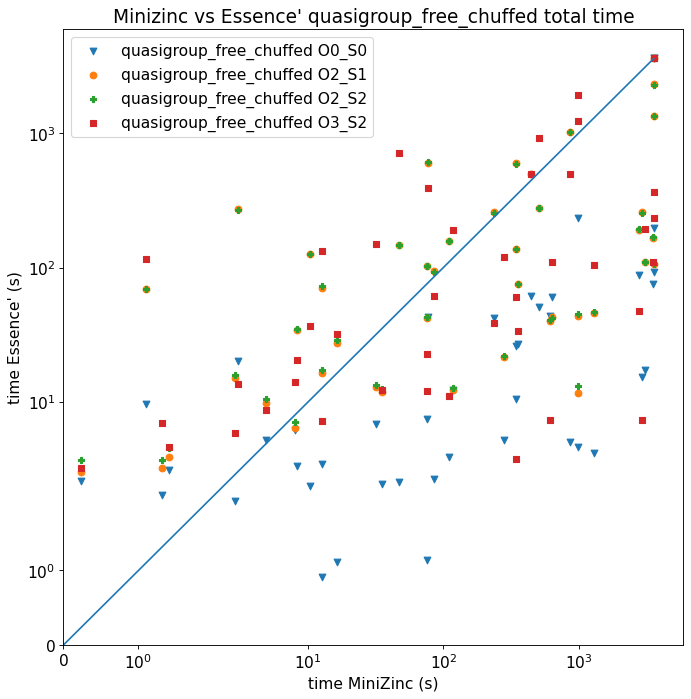

In [170]:
setupPlotSolverSolver()
plotAllOpts([quasigroup + "_free_chuffed"])
plt.legend(loc="best")

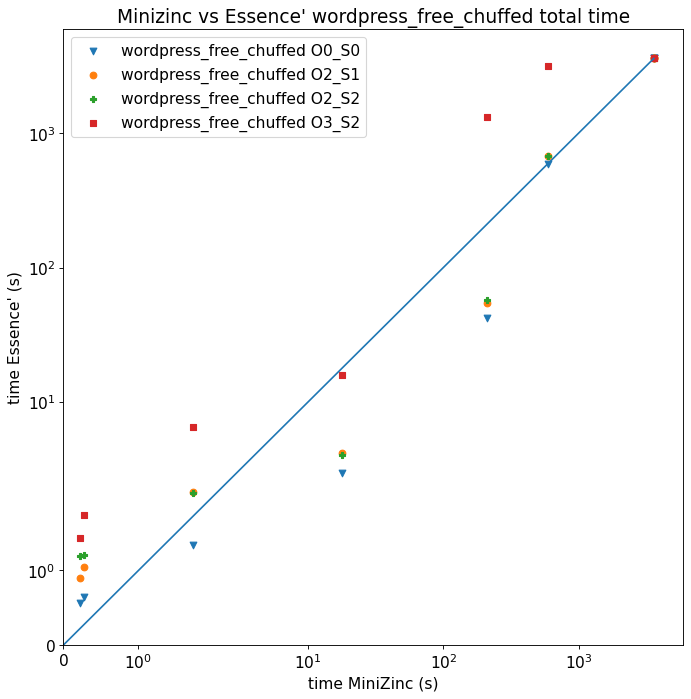

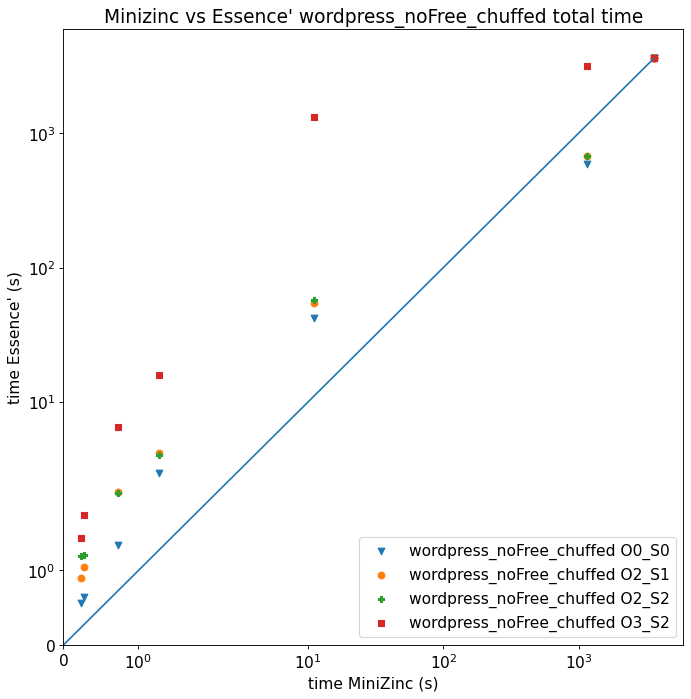

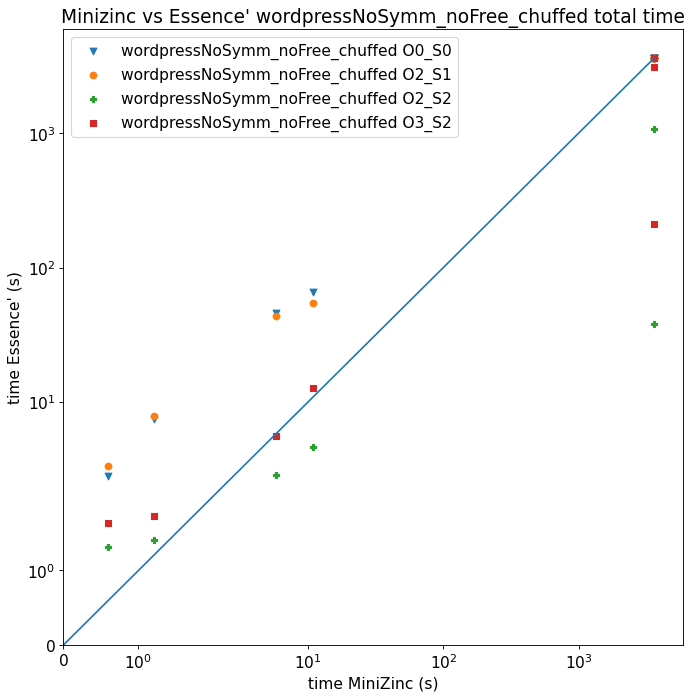

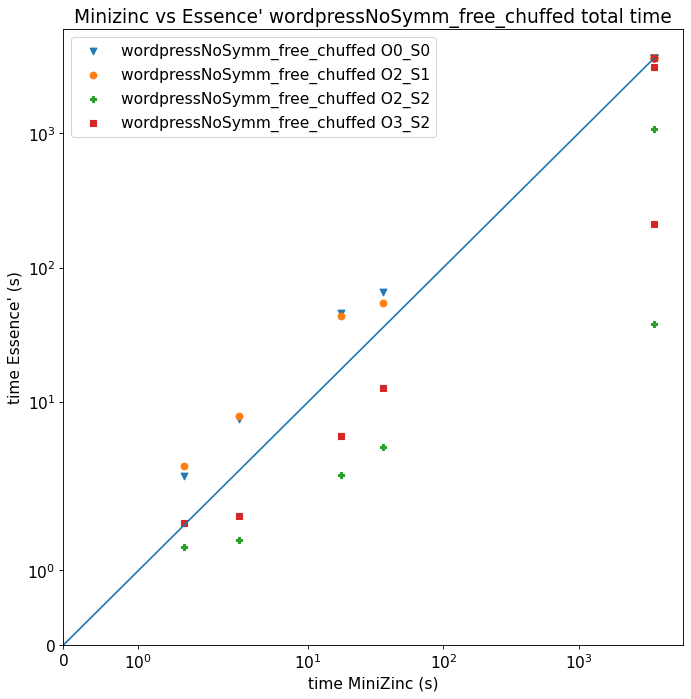

In [ ]:
for i in [wordpress, wordpressNoSymm]:
    for j in ["_free_chuffed"]:
        setupPlotSolverSolver()
        plotAllOpts([i + j])
        plt.legend(loc="best")

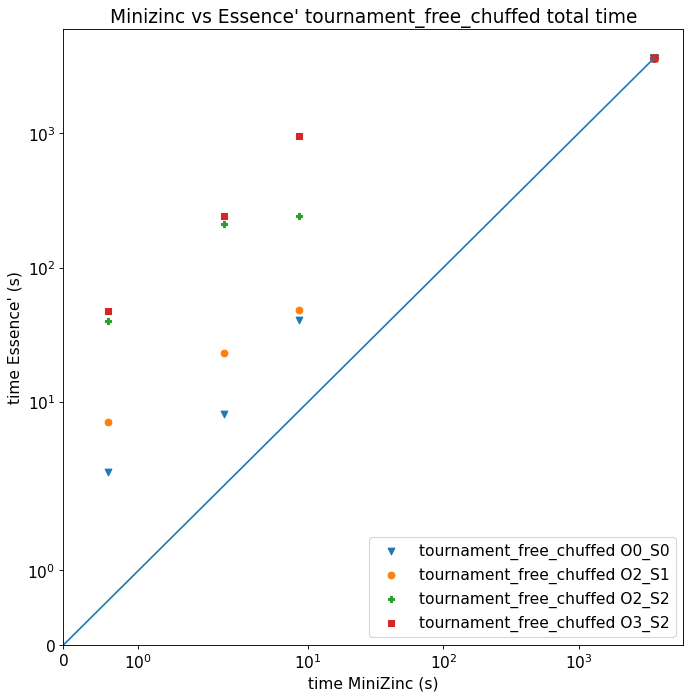

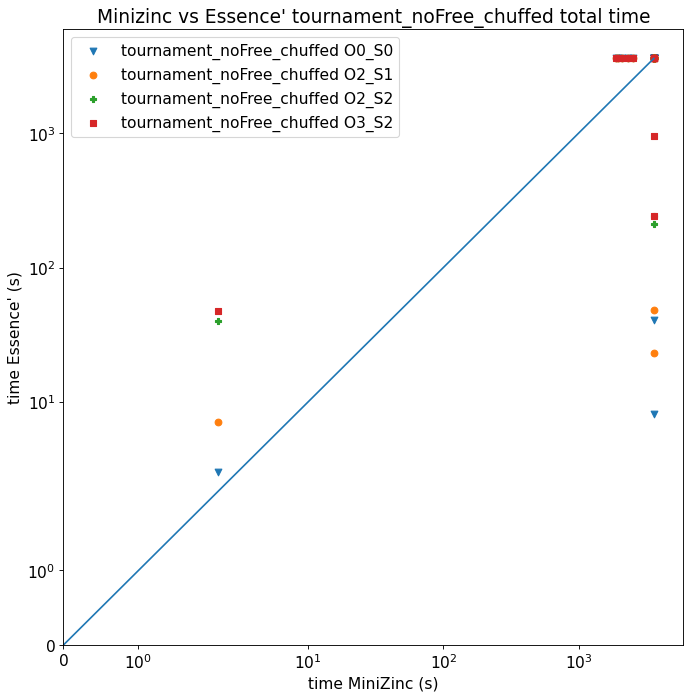

In [172]:
for i in ["_free_chuffed"]:
    setupPlotSolverSolver()
    plotAllOpts([tournament + i])
    plt.legend(loc="best")

['quasigroup_free_chuffed', 'wordpress_free_chuffed', 'wordpressNoSymm_free_chuffed', 'tournament_free_chuffed', 'mspsp_free_chuffed', 'cvrptw_free_chuffed', 'roster_free_chuffed']
['quasigroup_noFree_chuffed', 'wordpress_noFree_chuffed', 'wordpressNoSymm_noFree_chuffed', 'tournament_noFree_chuffed', 'mspsp_noFree_chuffed', 'cvrptw_noFree_chuffed', 'roster_noFree_chuffed']






/tmp/ipykernel_2301344/4165666539.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure(figsize=(10, 10), dpi=80)


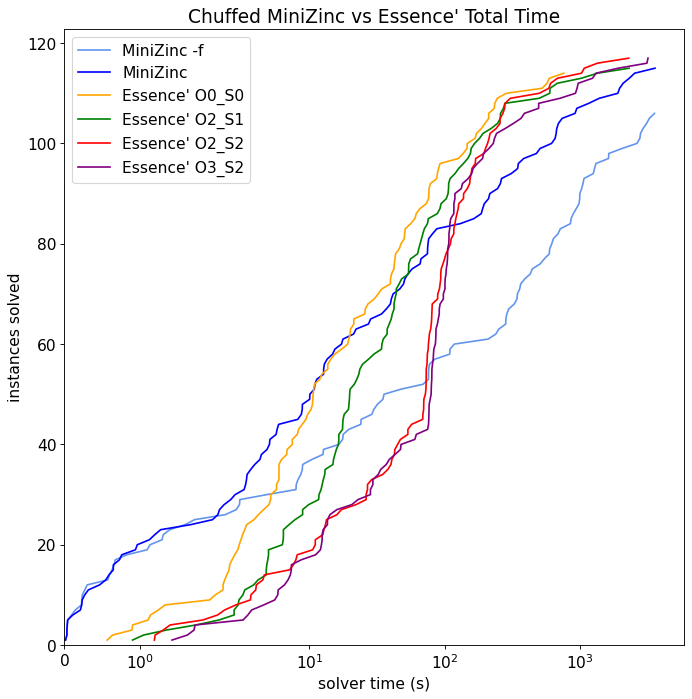

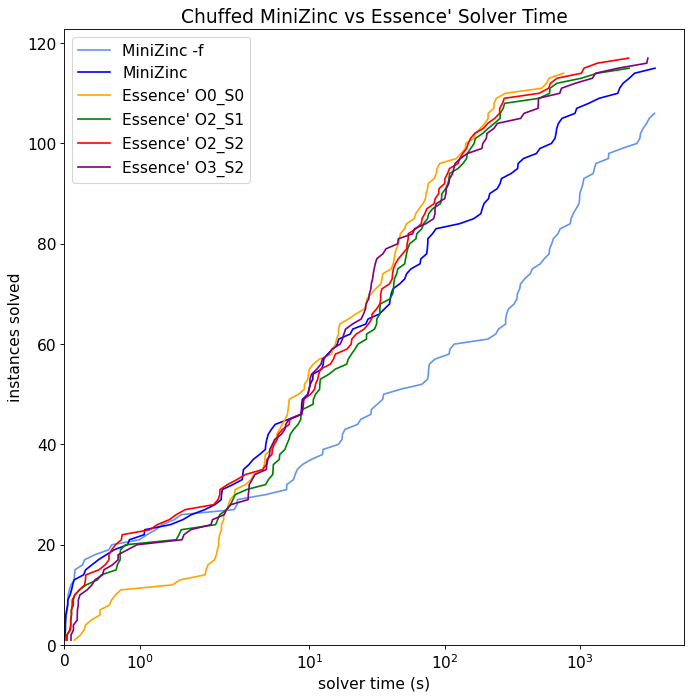

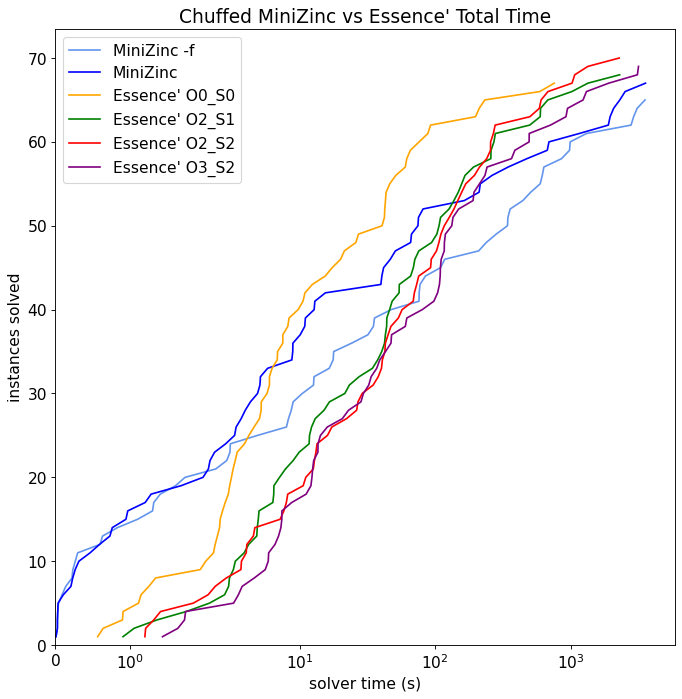

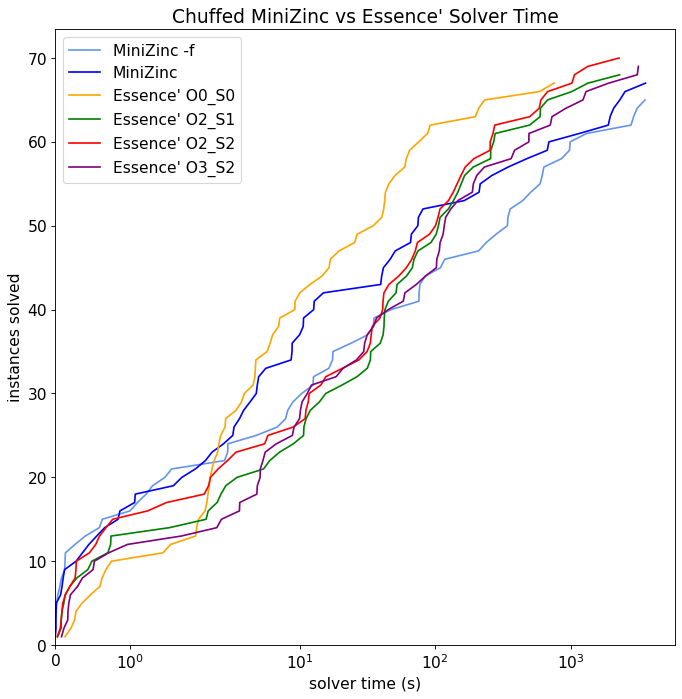

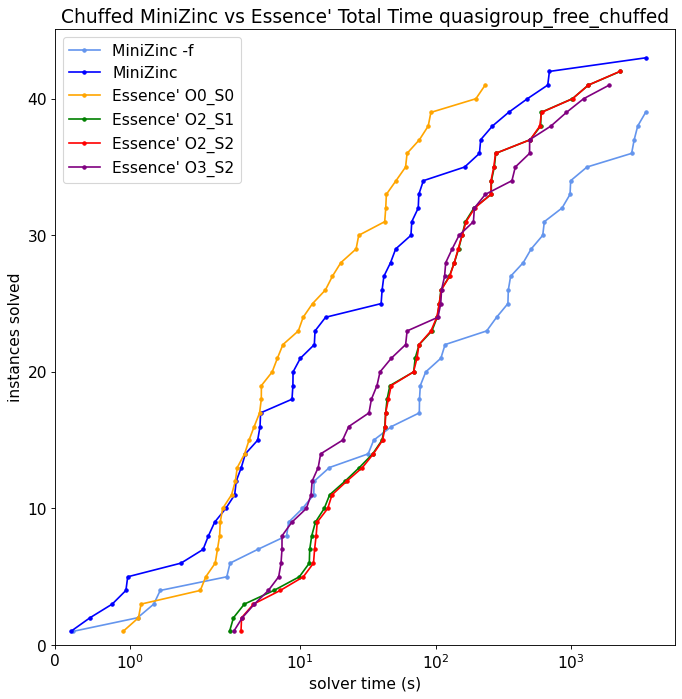

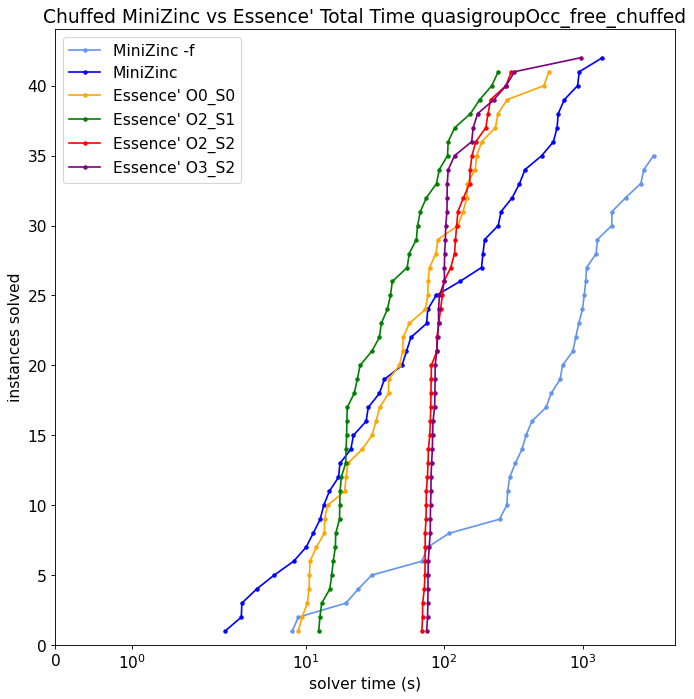

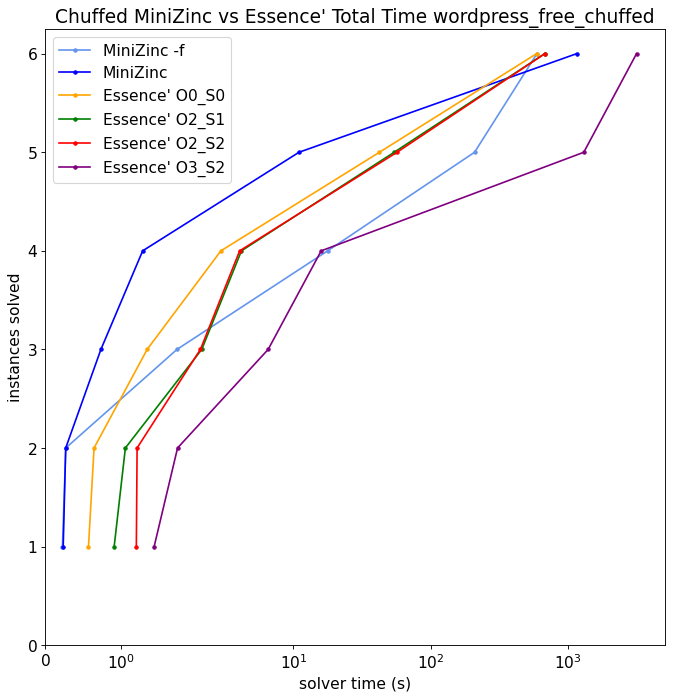

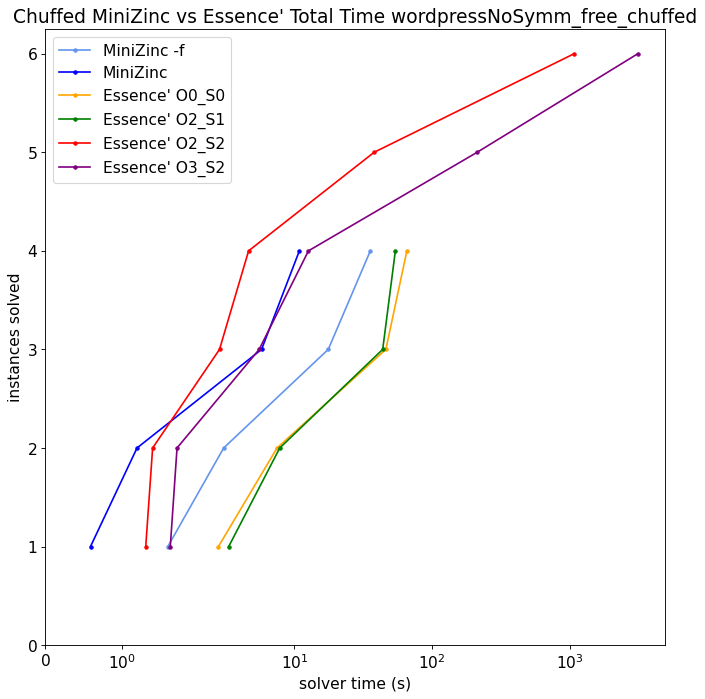

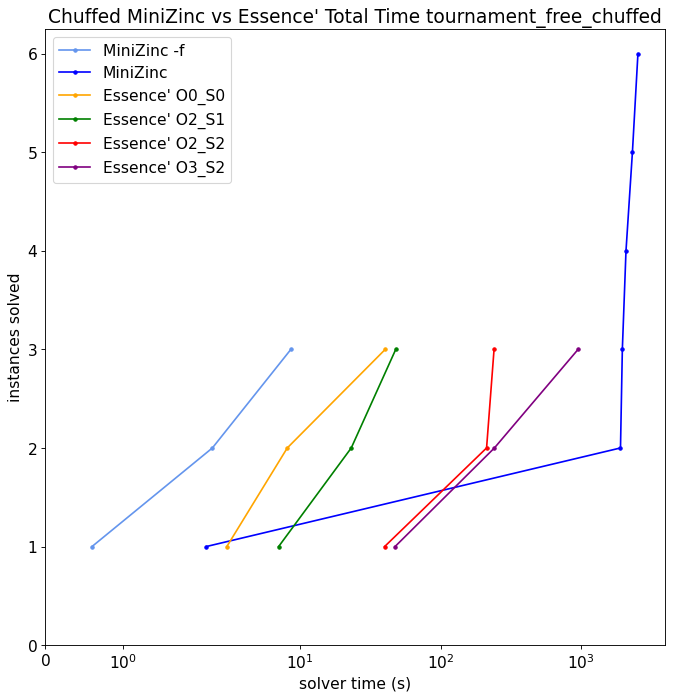

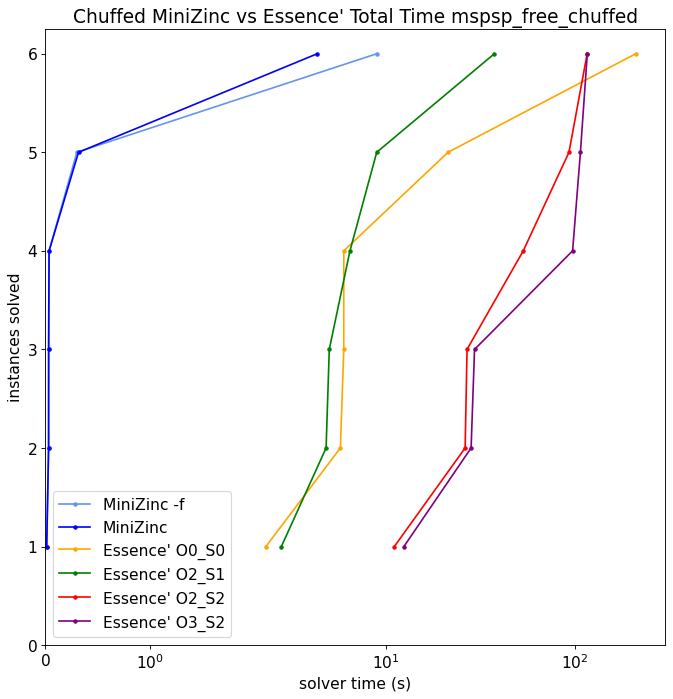

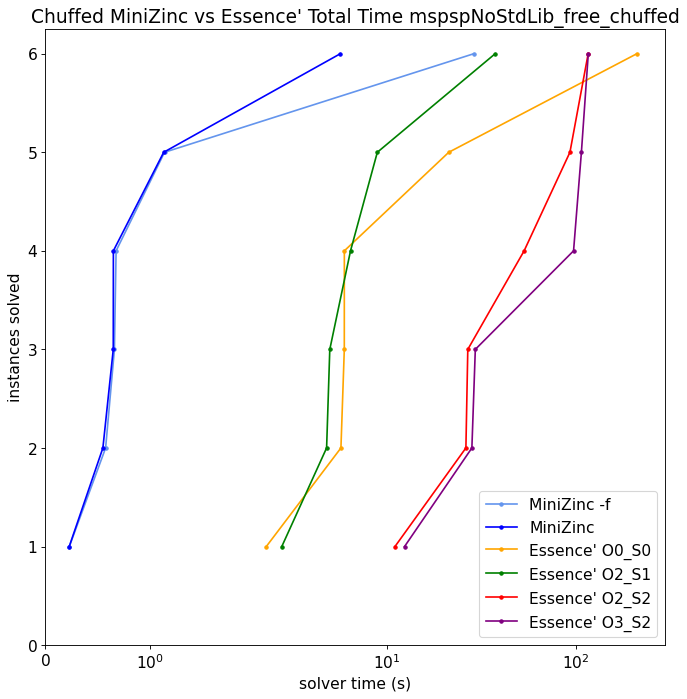

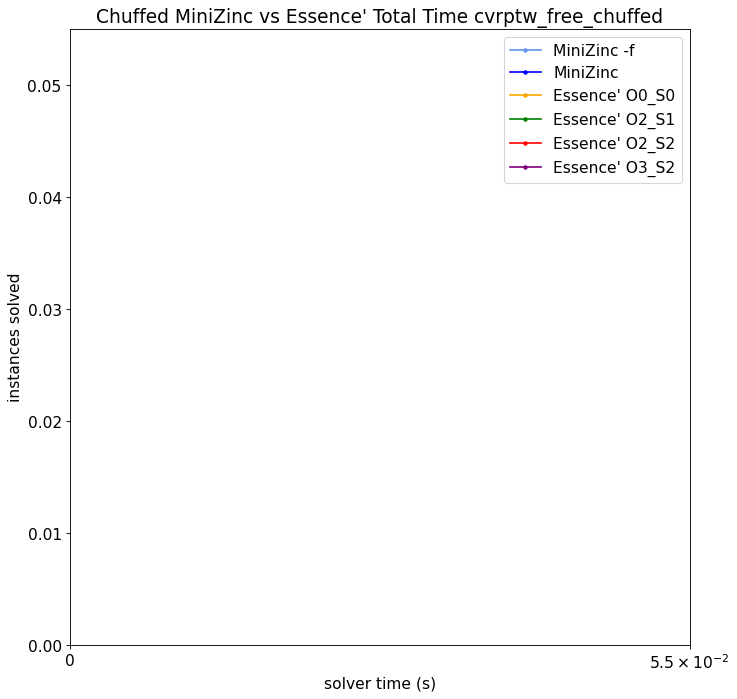

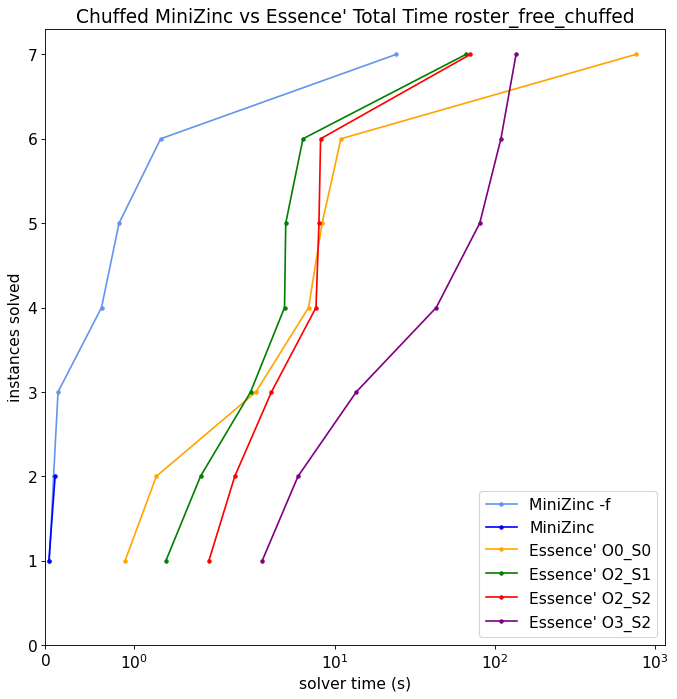

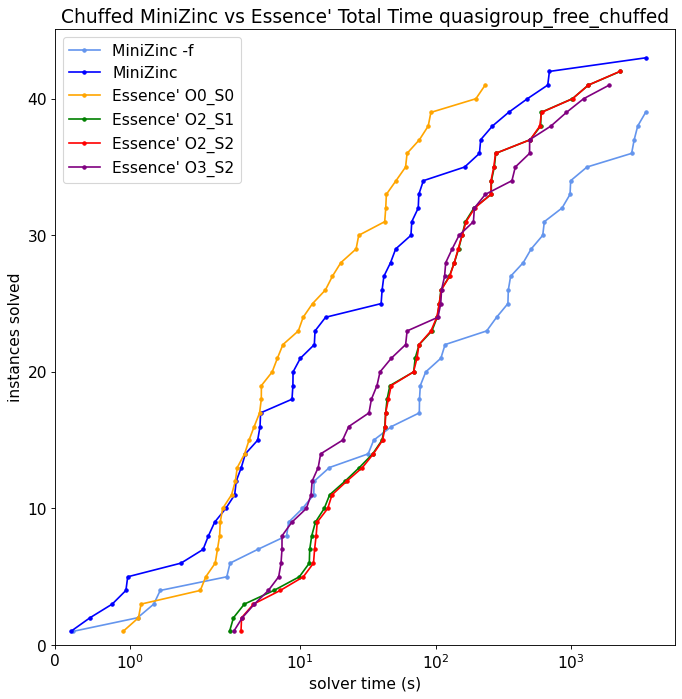

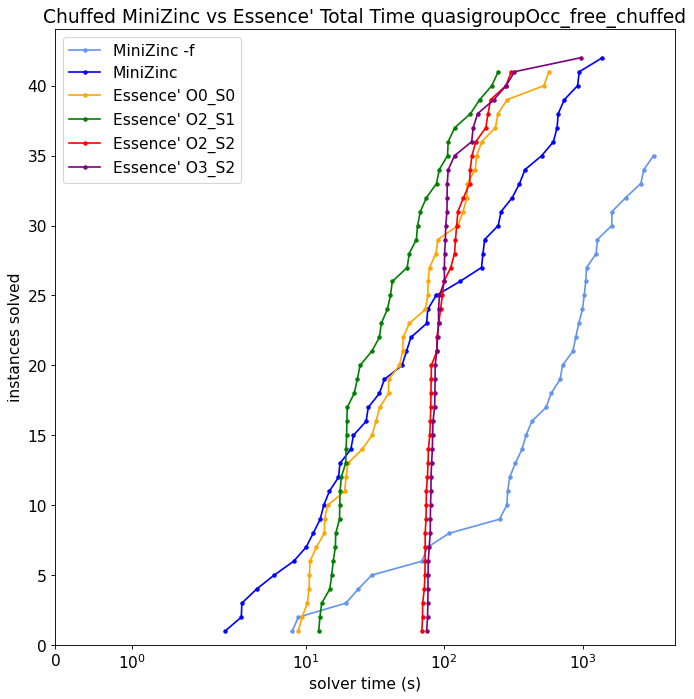

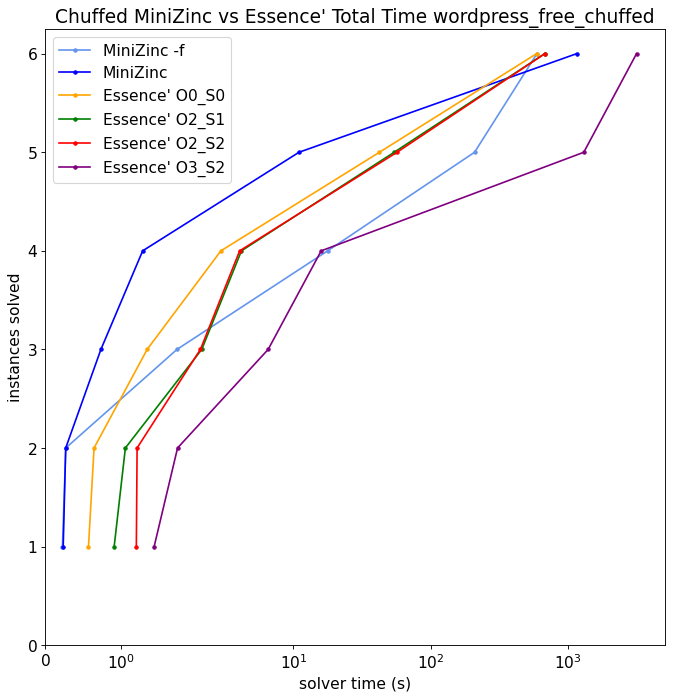

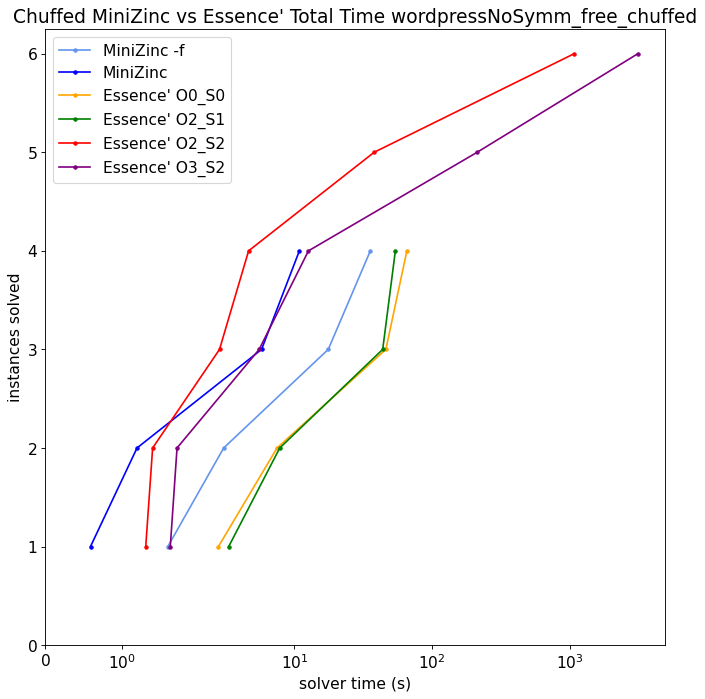

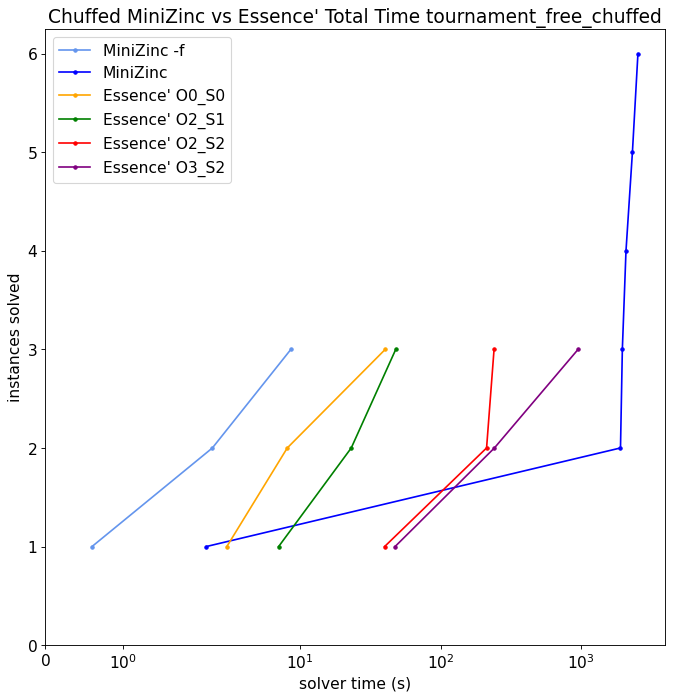

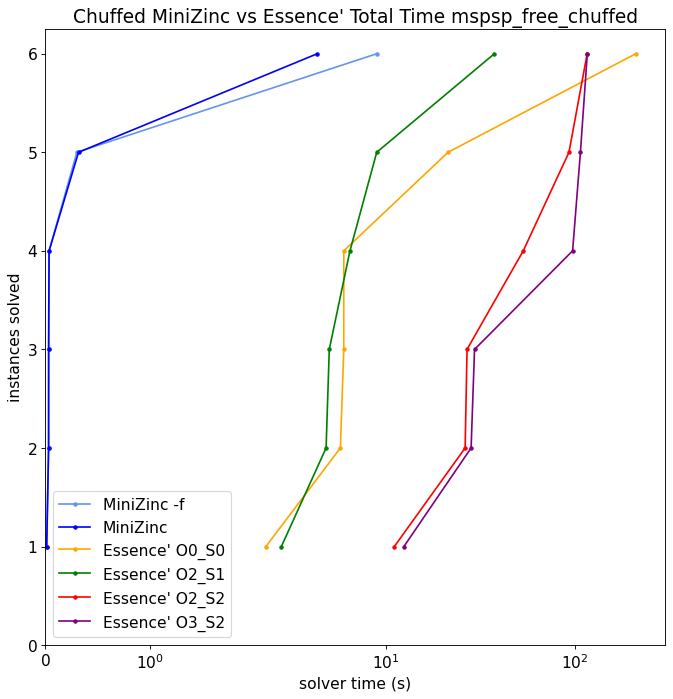

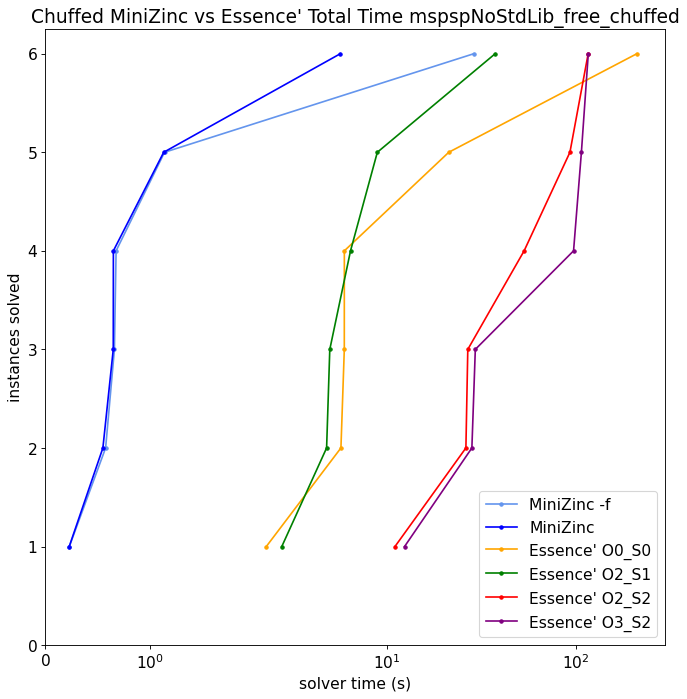

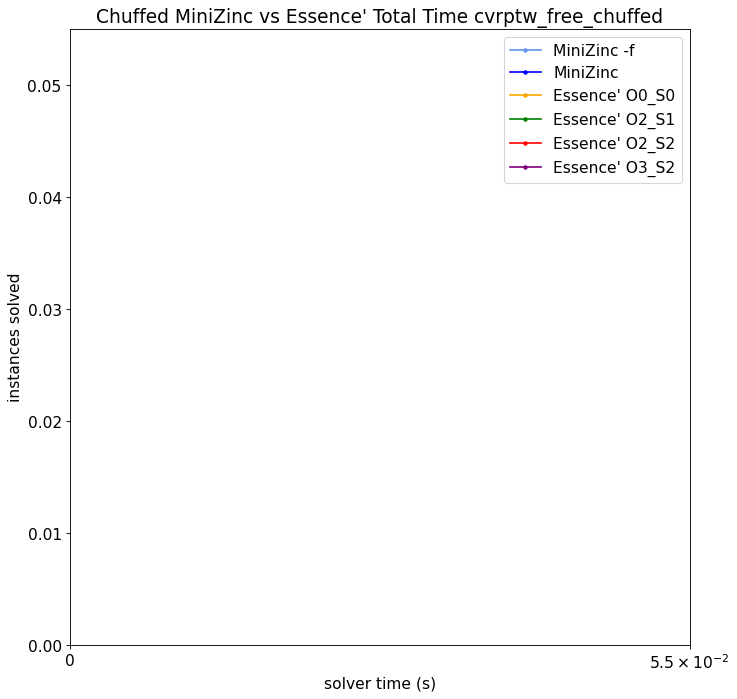

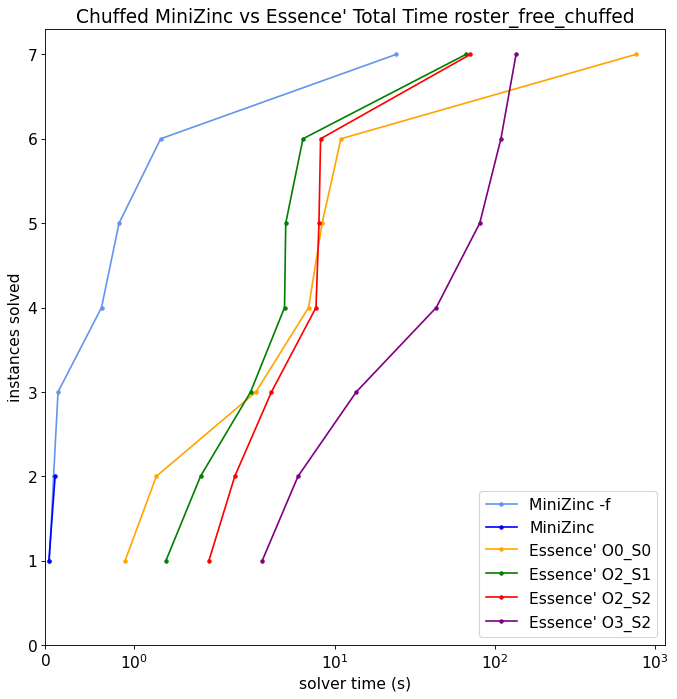

In [174]:
import numpy as np

def setupCumulativePlot(title):
    figure(figsize=(10, 10), dpi=80)
    plt.xlabel("solver time (s)")
    plt.ylabel("instances solved")
    plt.xscale("symlog")
    plt.title(title)
    plt.rcParams['font.size'] = 14

def createCumulativePlot(lst, opt, problemList=problems, label="Essence' ", color=None, markers=None, indexToGet=timingIndex):
    xValues = []
    allTimings = []
    for i in problemList:
        lstToGet = lst[i][opt]
        allTimings.extend([lstToGet[indexToGet][i] for i in range(len(lstToGet[indexToGet])) if not lstToGet[timeoutIndex][i]])
    allTimings.sort()
    # print(len(allTimings))
    yValues = [i for i in range(1, len(allTimings)+1)]
    xValues = allTimings
    plt.plot(xValues, yValues, label=label + (opt if opt else ""), color=color, marker=markers)
    plt.locator_params(axis="y", integer=True)
    

# TODO add mzn optimisation colors
coloring = {}
coloring["O0_S0"] = "orange"
coloring["O2_S1"] = "green"
coloring["O2_S2"] = "red"
coloring["O3_S2"] = "purple"
coloring["mzn"] = "blue"
coloring["mzn_free"] = "cornflowerblue"

originalFreeProblems = freeProblems.copy()
originalNoFreeProblems = noFreeProblems.copy()

for i in [mspspNoStdLib, quasigroupOcc]:
# for i in [tournament, roster]:
    originalFreeProblems.remove(i + "_free_chuffed")
    originalNoFreeProblems.remove(i + "_noFree_chuffed")

print(originalFreeProblems)
print(originalNoFreeProblems)

setupCumulativePlot("Chuffed MiniZinc vs Essence' Total Time")
for mzn_opt in mzn_optimisations:
    createCumulativePlot(allMinizincTimings, mzn_opt, problemList=freeProblems, label="MiniZinc -f", color=coloring["mzn_free"])
    createCumulativePlot(allMinizincTimings, mzn_opt, problemList=noFreeProblems, label="MiniZinc", color=coloring["mzn"])
print()
for opt in optimisations:
    createCumulativePlot(allEprimeTimings, opt, problemList=freeProblems, color=coloring[opt])
plt.legend(loc="best")
plt.xlim(left=0)
plt.ylim(bottom=0)

setupCumulativePlot("Chuffed MiniZinc vs Essence' Solver Time")
for mzn_opt in mzn_optimisations:
    createCumulativePlot(allMinizincTimings, mzn_opt, problemList=freeProblems, label="MiniZinc -f", color=coloring["mzn_free"], indexToGet=solverTimeIndex)
    createCumulativePlot(allMinizincTimings, mzn_opt, problemList=noFreeProblems, label="MiniZinc", color=coloring["mzn"], indexToGet=solverTimeIndex)
print()
for opt in optimisations:
# for opt in ["O0_S0"]:
    createCumulativePlot(allEprimeTimings, opt, problemList=freeProblems, color=coloring[opt], , indexToGet=solverTimeIndex)
plt.legend(loc="best")
plt.xlim(left=0)
plt.ylim(bottom=0)


In [175]:
# setupCumulativePlot("cactus no free flag minizinc vs essence")
# print()

# for opt in optimisations:
# # for opt in ["O0_S0"]:
#     createCumulativePlot(problemList=noFreeProblems, opt=opt)
# plt.legend(loc="best")

# setupCumulativePlot("cactus chuffed minizinc vs essence")
# print()
# createCumulativePlot(problemList=chuffedProblems)
# for opt in optimisations:
# # for opt in ["O0_S0"]:
#     createCumulativePlot(problemList=chuffedProblems, opt=opt)
# plt.legend(loc="best")

# setupCumulativePlot("cactus gecode minizinc vs essence")
# print()
# createCumulativePlot(problemList=gecodeProblems)
# for opt in optimisations:
# # for opt in ["O0_S0"]:
#     createCumulativePlot(problemList=gecodeProblems, opt=opt)
# plt.legend(loc="best")

# setupCumulativePlot("selective cactus -f flag minizinc vs essence")
# test = [tournamentFree, rosterFree, mspsp, cvrptw, wordpress, wordpressNoSymm, quasigroup]
# createCumulativePlot(problemList=test)
# for opt in optimisations:
# # for opt in ["O0_S0"]:
#     createCumulativePlot(problemList=test, opt=opt)
# plt.legend(loc="best")

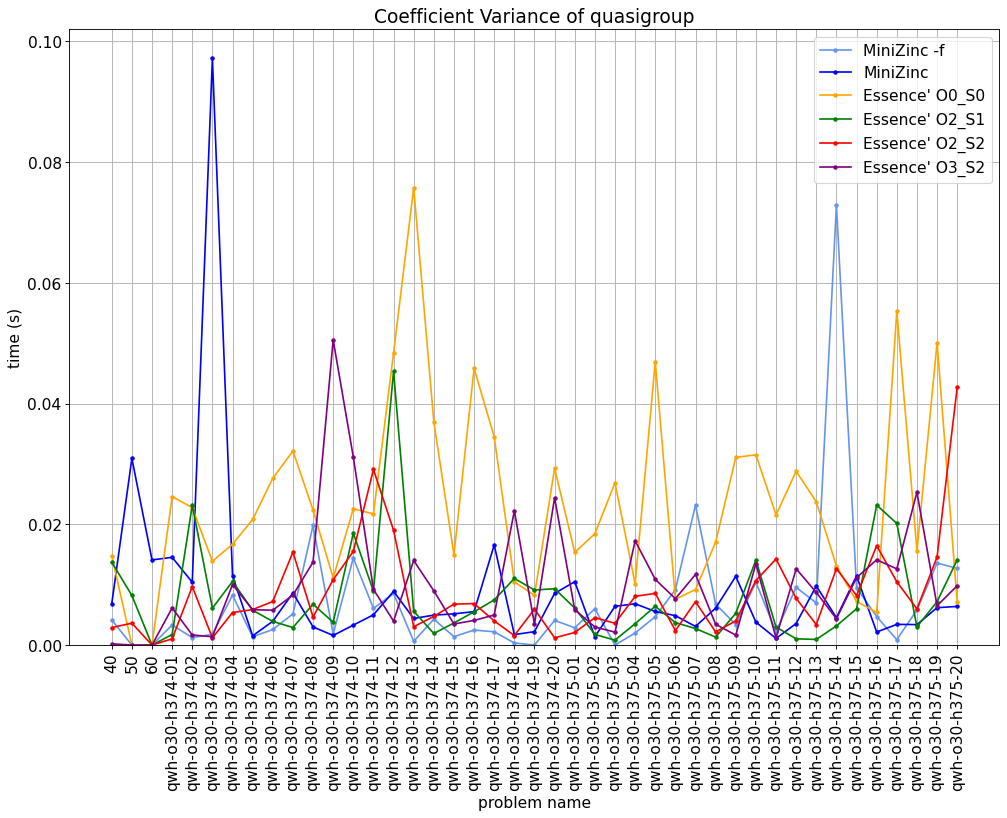

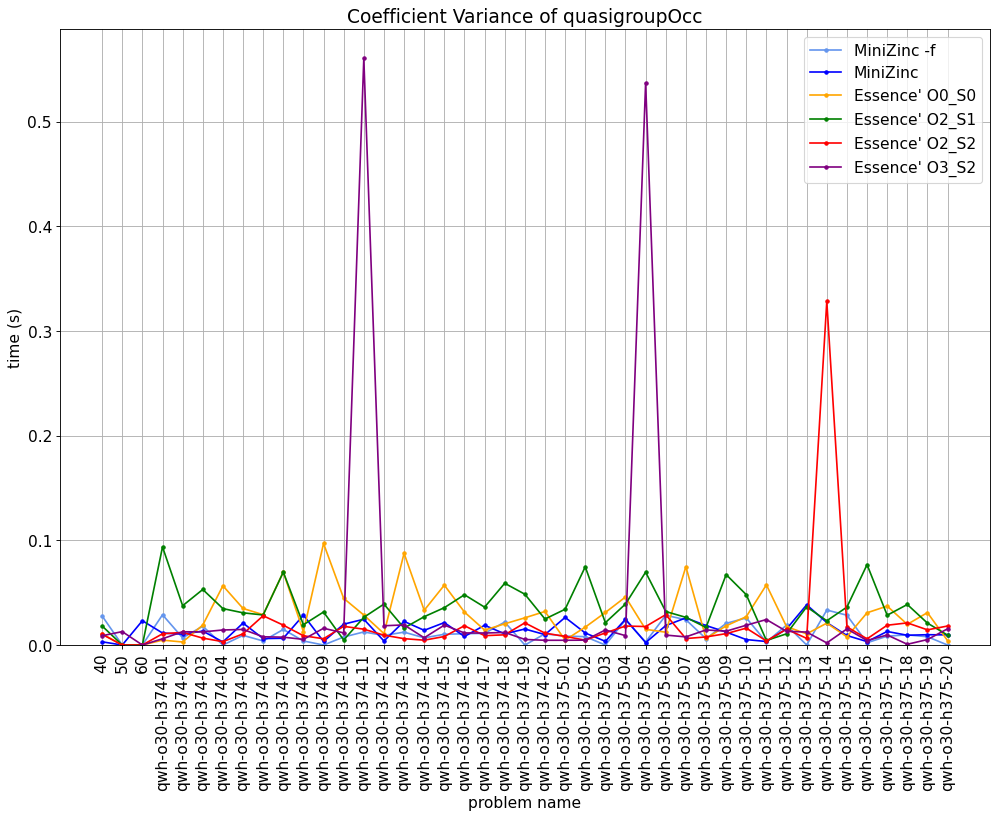

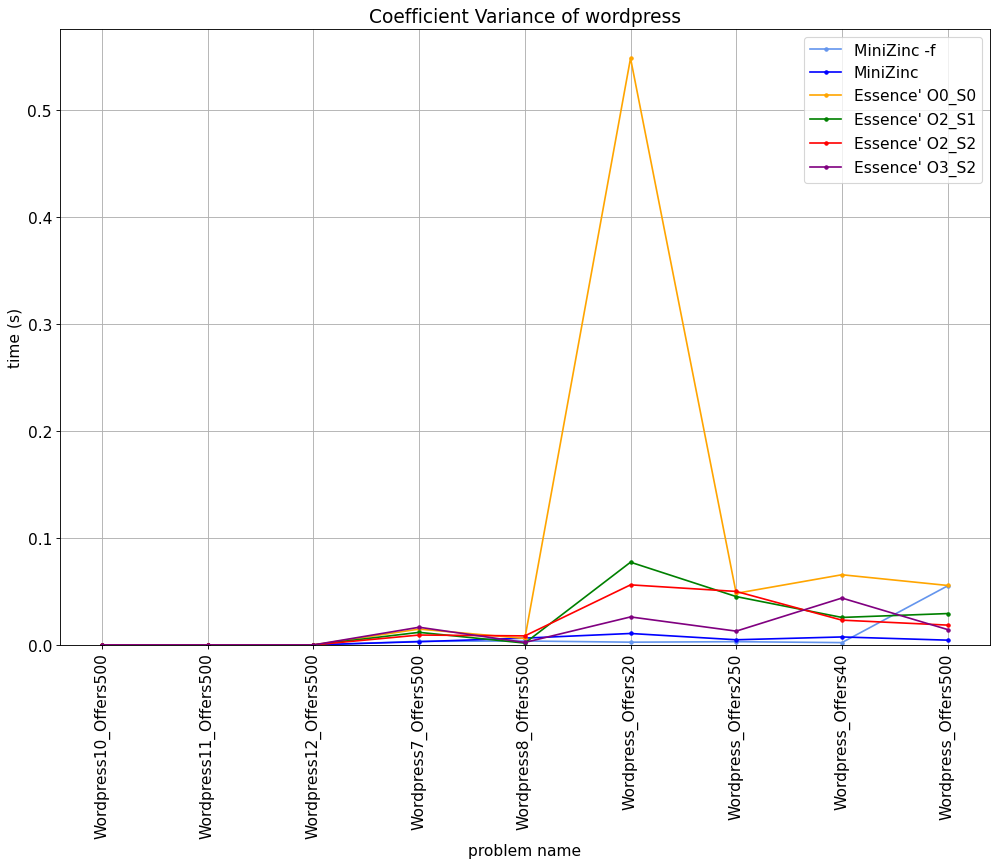

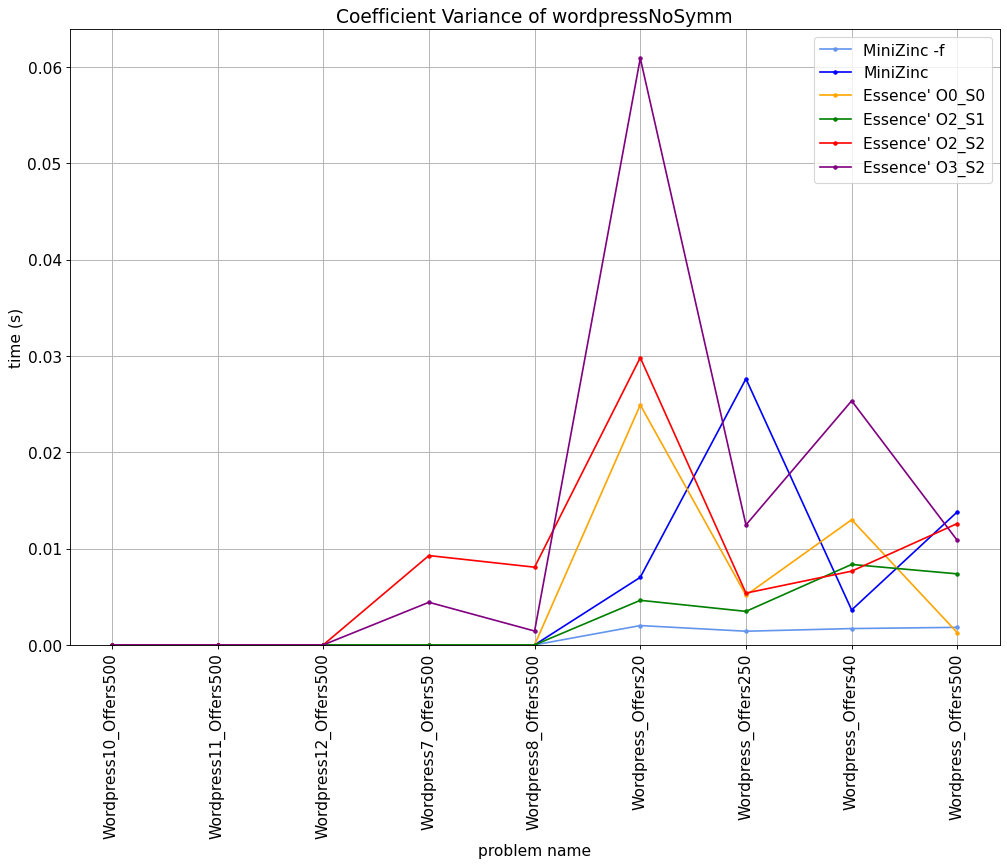

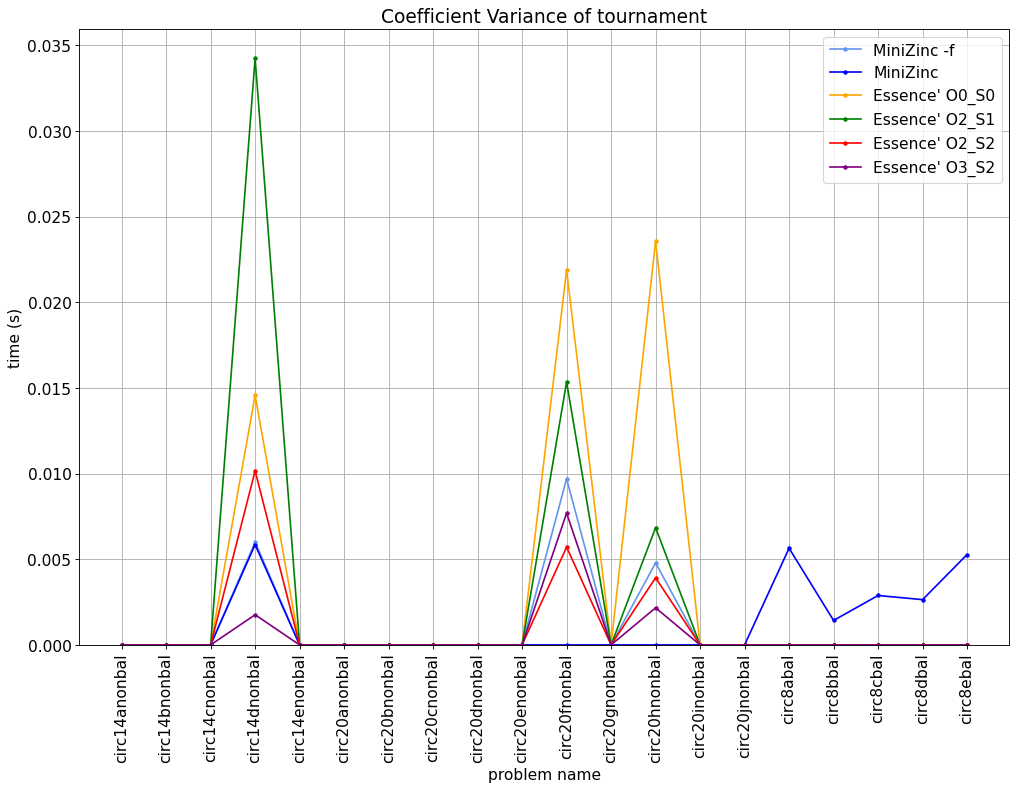

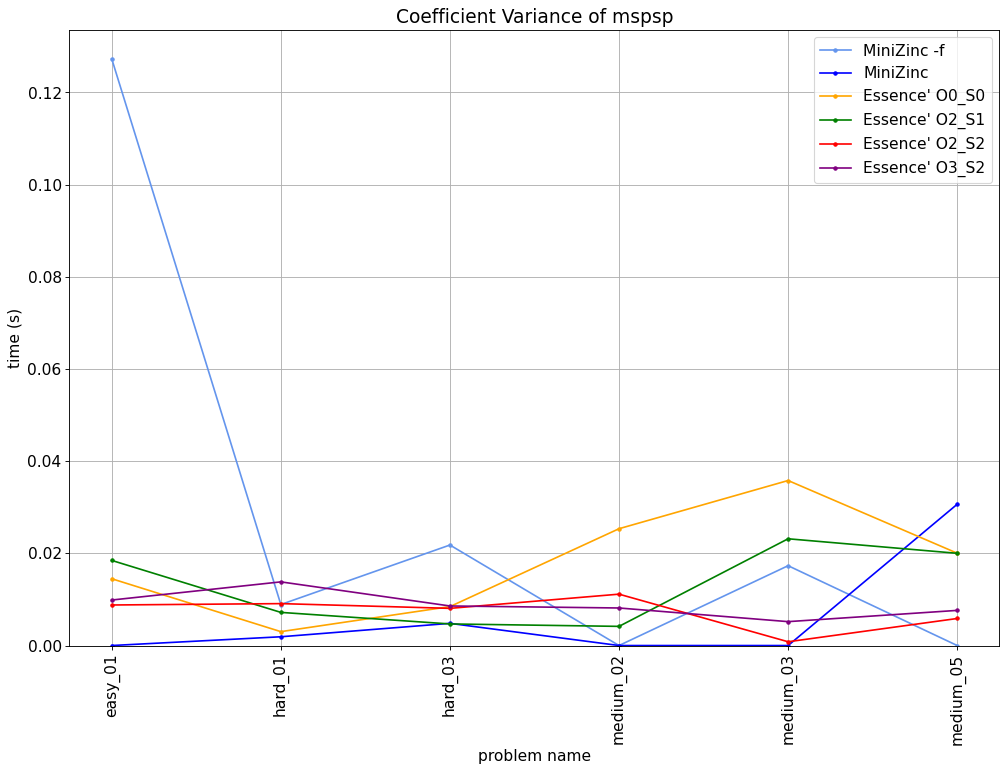

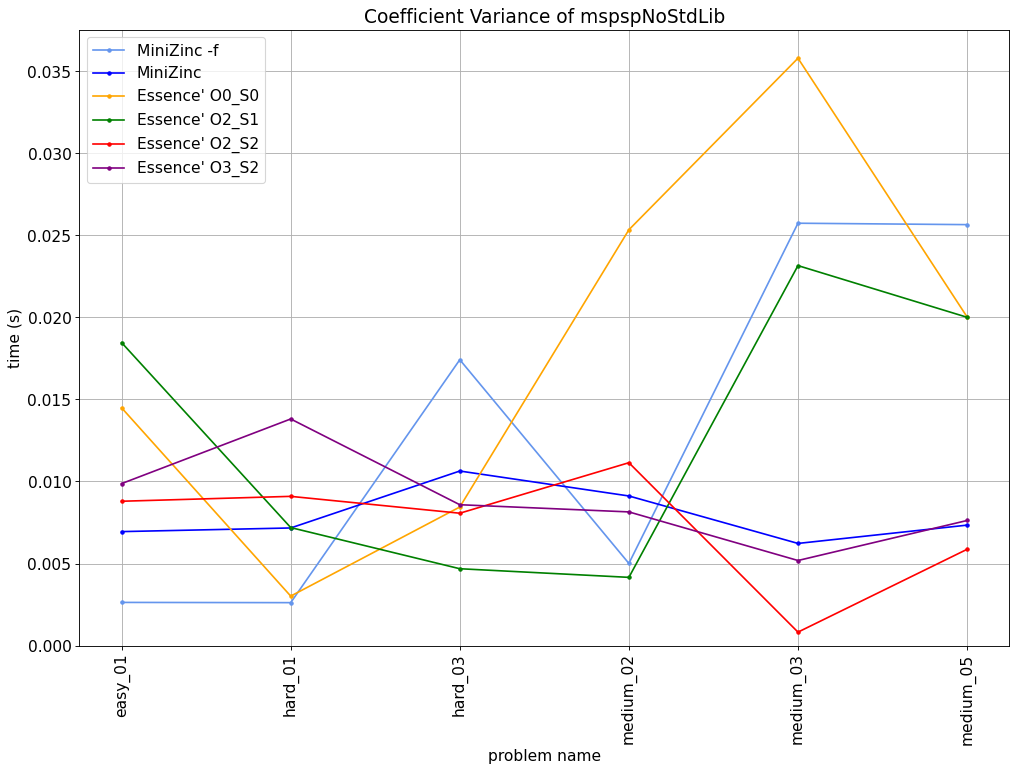

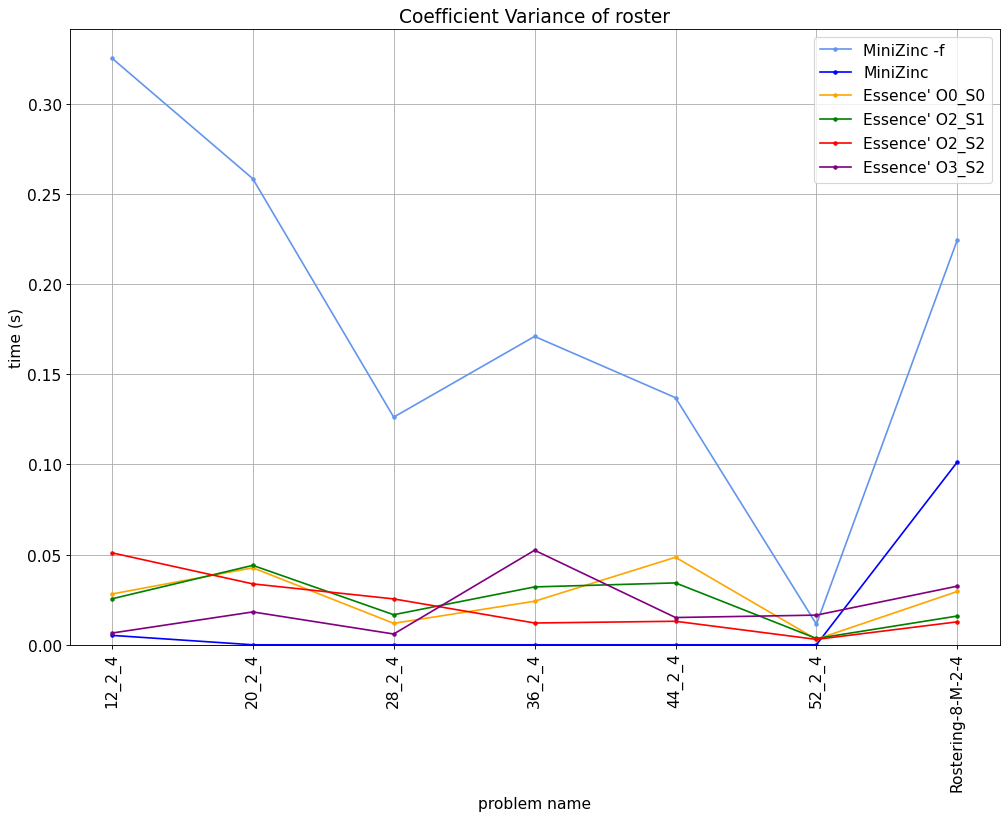

In [176]:

def getData(dataToExtract):
    # sorts the data alphabetically
    # unpacks the data
    # zips the data into problemName, problemData 
    xData, yData = zip(*sorted(dataToExtract))
    extractedY = {}
    for i in dataKeys:
        extractedY[i] = ([y[i] for y in yData])
        extractedY[i + "_all_runs"] = ([y[i + "_all_runs"] for y in yData])
        # extractedY.append(list(map(lambda y : y[i], yData)))
        if i != "timeout":
            extractedY[i+"_CV"] = ([y[i+"_CV"] for y in yData])
            # extractedY.append(list(map(lambda y : y[i+"_stdev"], yData)))
    res = {}
    res['instances'] = xData
    res['data'] = extractedY 
    return res

eprimeDiffTimings = {}
minizincDiffTimings = {}

for i in problems:
    minizincDiffTimings[i] = getData(minizincData[i])
    # print(minizincData[i])
    # print()
    eprimeDiffTimings[i] = {}
    for j in optimisations:
        eprimeDiffTimings[i][j] = getData(eprimeData[i][j])




# def setupStdPlot(title):
#     figure(figsize=(15, 10), dpi=80)
#     plt.rcParams['font.size'] = 14
#     plt.xlabel("problem name")
#     plt.ylabel("time (s)")
#     plt.xticks(rotation = 90)
#     # plt.yscale("symlog")
#     plt.title(title)
#     plt.grid()

# LEGACY debug coefficient variance
# def plotStd(toGraph, label=None, stdDevIndex="time_CV", color=None):
#     xVals, yVals = toGraph["instances"], toGraph["data"][stdDevIndex]
#     xVals = [i.split(".")[0] for i in xVals]
#     plt.plot(xVals, yVals, label=label, color=color, marker='.', linestyle="-")

# for problem in freeProblems:
#     if 'cvr' in problem:
#         continue
#     setupStdPlot("Coefficient Variance of " + problem.split("_")[0])
#     plotStd(minizincDiffTimings[problem], label="MiniZinc -f", color=coloring["mzn_free"])
#     plotStd(minizincDiffTimings[problem.split("_")[0] + "_noFree_chuffed"], label="MiniZinc", color=coloring["mzn"])
#     for opt in optimisations:
#         plotStd(eprimeDiffTimings[problem][opt], label="Essence' " + opt, color=coloring[opt])
#     plt.ylim(bottom=0)
#     plt.legend(loc="best")
    

In [177]:
def determine_mean(eprime_lst, mzn_lst, use_arithmetic = False, index_tofind = timingIndex):
    mean = 1 if not use_arithmetic else 0 # default values if the array is empty
    mean_arr = []
    for instance in range(len(mzn_lst[problemIndex])):
        if index_tofind == initIndex:
            mean_arr.append(eprime_lst[initIndex][instance] / mzn_lst[initIndex][instance])
        elif not eprime_lst[timeoutIndex][instance] and not mzn_lst[timeoutIndex][instance]:
        # elif not eprime_lst[timeoutIndex][instance] or not mzn_lst[timeoutIndex][instance]:
            mean_arr.append(eprime_lst[index_tofind][instance] / mzn_lst[index_tofind][instance])
    if len(mean_arr) > 0:
        if use_arithmetic:
            mean = statistics.mean(mean)
        else:
            mean = statistics.geometric_mean(mean_arr)
    # if mean > 1, means minizinc better, 
    # if mean < 1 essence' better, 
    # if mean == 1 then equal
    return (mean, mean_arr)

_free_chuffed 10.318683501266115
_free_chuffed 23.74204285871119

_noFree_chuffed 8.81348786671565
_noFree_chuffed 24.131966320961624



In [179]:

print('essence/minizinc free flag')
print()
print('Problem,O0_S0/O0,O2_S1/O1,O3_S2/O5')
for problem in problems:
    if 'noFree' in problem:
        continue
    line = [problem.split("_")[0]]
    for i in range(len(optimisations)):
        geometric, _ = determine_mean(allEprimeTimings[problem][optimisations[i]], allMinizincTimings[problem][mzn_optimisations[i]], index_tofind=timingIndex, use_arithmetic=False)
        line.append(str(round(geometric,2)))
    print(",".join(line))


Problem,O0_S0,O2_S1,O2_S2,O3_S2
quasigroup,0.12,0.74,0.76,0.64
quasigroupOcc,0.12,0.09,0.26,0.27
wordpress,0.73,1.05,1.13,4.08
wordpressNoSymm,2.13,2.12,0.3,0.5
tournament,4.32,8.6,54.88,95.9
mspsp,104.46,66.75,375.65,445.71
mspspNoStdLib,10.12,6.47,36.4,43.19
cvrptw,1,1,1,1
roster,14.87,9.43,12.83,54.07


In [182]:
import numpy as np 
import random

index = timingIndex

def find_interval(eprime_lst, mzn_lst, problem="", opt="", index=timingIndex):
    lst = []
    for instance in range(len(mzn_lst[problemIndex])):
        if index == initIndex:
            lst.append(eprime_lst[index][instance] / mzn_lst[index][instance])
        # interval is either including one of the solvers solving the problem, or only using data
        # where both solvers solve the problem within the time limit
        elif not eprime_lst[timeoutIndex][instance] and not mzn_lst[timeoutIndex][instance]:
        # elif not eprime_lst[timeoutIndex][instance] or not mzn_lst[timeoutIndex][instance]:
            lst.append(eprime_lst[index][instance] / mzn_lst[index][instance])
    if len(lst) > 0:
        bell = []
        for i in range(100000):
            to_take = len(lst)
            y = random.choices(lst, k=to_take)
            avg = statistics.geometric_mean(y)
            bell.append(avg)
        # figure(figsize=(10, 10), dpi=80)
        # bell_sorted = sorted(bell)
        # plt.title(problem + " " + opt)
        # plt.hist(bell_sorted, bins = 20)
        left = np.quantile(bell, 0.025)
        right = np.quantile(bell, 0.975)
        # print(problem, opt, round(left,2), round(right,2), '----------------- OUT OF RANGE' if left <= 1 and right >= 1 else '')
        return('[' + str(round(left,2)) + "-" + str(round(right,2)) + ']')
    return '[1-1]'


print('essence/minizinc')
print('Problem,O0_S0/O0,O2_S1/O1,O3_S2/O5')
for problem in problems:
    if 'noFree' in problem:
        continue
    line = [problem.split("_")[0]]
    for i in range(len(mzn_optimisations)):
        eprime_lst = allEprimeTimings[problem][optimisations[i]]
        mzn_lst = allMinizincTimings[problem][mzn_optimisations[i]]
        line.append(find_interval(eprime_lst, mzn_lst, index=solverTimeIndex))
    if len(line) == 1:
        print(line[0])
    else:
        print(",".join(line))
print()
        
        

Problem,O0_S0,O2_S1,O2_S2,O3_S2
quasigroup,[0.05-0.2],[0.37-1.4],[0.37-1.38],[0.27-1.12]
quasigroupOcc,[0.06-0.17],[0.02-0.06],[0.02-0.06],[0.02-0.06]
wordpress,[0.25-1.51],[0.28-1.57],[0.28-1.55],[1.38-4.43]
wordpressNoSymm,[1.76-2.52],[1.62-2.43],[0.07-0.14],[0.11-0.15]
tournament,[4.27-5.11],[3.66-10.14],[4.04-9.82],[35.85-107.01]
mspsp,[53.57-176.71],[4.08-8.84],[3.62-8.31],[5.73-17.99]
mspspNoStdLib,[19.85-62.33],[1.6-3.31],[1.59-3.06],[3.09-6.53]
cvrptw,[1-1],[1-1],[1-1],[1-1]
roster,[7.73-19.4],[2.03-4.65],[1.92-4.71],[15.91-94.0]


In [178]:
originalFreeProblems = freeProblems.copy()
originalNoFreeProblems = noFreeProblems.copy()

for i in [mspspNoStdLib, quasigroupOcc]:
# for i in [tournament, roster]:
    originalFreeProblems.remove(i + "_free_chuffed")
    originalNoFreeProblems.remove(i + "_noFree_chuffed")

def totalGeometricMeans(index):
    for i in range(len(optimisations)):
        totalGeometric = []
        mzn_lst = []
        eprime_lst = []
        # for problem in originalNoFreeProblems:
        # for problem in originalFreeProblems:
        for problem in problems:
            if 'noFree' in problem:
                continue
            eprime_lst.extend(allEprimeTimings[problem][optimisations[i]])
            mzn_lst.extend(allMinizincTimings[problem][mzn_optimisations[i]])
            geometric, arr = determine_mean(allEprimeTimings[problem][optimisations[i]],  allMinizincTimings[problem][mzn_optimisations[i]],index_tofind=index)

            # geometric, arr = determine_mean(allEprimeTimings[problem]["O2_S2"], allEprimeTimings[problem]["O2_S1"],index_tofind=initIndex)
            totalGeometric.extend(arr)
        print('total', 'mzn_opt:' + mzn_opt, 'eprime_opt:' + opt, statistics.geometric_mean(totalGeometric), 'interval: ' + find_interval(eprime_lst, mzn_lst, index=index))


print('init time total geometric mean')
totalGeometricMeans(initIndex)

print('solver time total geometric mean')
totalGeometricMeans(solverTimeIndex)

print('total time total geometric mean')
totalGeometricMeans(timingIndex)


total O0_S0 5.774663418378538
total O2_S1 13.892985818782261
total O2_S2 42.50413820268692
total O3_S2 52.320297918995045


In [191]:
index = initIndex
lst = []

def plot_hist(lst, is_plotting=False):
    if len(lst) > 0:
        bell = []
        for i in range(100000):
            to_take =len(lst)
            y = random.choices(lst, k=to_take)
            avg = statistics.geometric_mean(y)
            bell.append(avg)
       
        if is_plotting: 
            figure(figsize=(15, 10), dpi=100)
            bell_sorted = sorted(bell)
            plt.title("bootstrap histogram")
            plt.xlabel('bootstrap')
            plt.ylabel('frequency')
            plt.hist(bell_sorted, bins = 30, color='c', edgecolor='black')
            # plt.xlim(right=1.2)
        left = np.quantile(bell, 0.025)
        right = np.quantile(bell, 0.975)
        print('overall', left, right, '----------------- OUT OF RANGE' if left <= 1 and right >= 1 else '')
        


for problem in problems:
    # if 'noFree' in problem:
    #     continue
    for i in range(len(mzn_optimisations)):
        eprime_lst = allEprimeTimings[problem][optimisations[i]]
        mzn_lst = allMinizincTimings[problem][mzn_optimisations[i]]

        for instance in range(len(mzn_lst[problemIndex])):
            if index == initIndex:
                lst.append(eprime_lst[index][instance] / mzn_lst[index][instance])
                
            # elif not eprime_lst[timeoutIndex][instance] and not mzn_lst[timeoutIndex][instance]:
            elif not eprime_lst[timeoutIndex][instance] or not mzn_lst[timeoutIndex][instance]:
                lst.append(eprime_lst[index][instance] / mzn_lst[index][instance])
plot_hist(lst)



overall 5.185381766868388 6.317131975940703 


In [192]:
# index = "solveTime_all_runs"
# lst = []
# # for problem in originalFreeProblems:
# for problem in problems:
#     if 'noFree' in problem:
#         continue
#     for opt in optimisations:
#         eprime_lst = eprimeDiffTimings[problem][opt]["data"]
#         mzn_lst = minizincDiffTimings[problem]["data"]

#         for instance in range(len(mzn_lst["timeout"])):
#             for i in range(3):
#                 for j in range(3):
#                     if not eprime_lst["timeout_all_runs"][instance][i] and not mzn_lst["timeout_all_runs"][instance][j]:
#                         lst.append(eprime_lst[index][instance][i] / mzn_lst[index][instance][j])
# plot_hist(lst)